In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('dataset1 - dataset1.csv')

# 1. Parse Dates to ensure accurate filtering
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])
df['contract_end_date'] = pd.to_datetime(df['contract_end_date'])

# 2. Industry Imputation
# Recommendation: Use 'Unknown' to avoid biasing the data with guesses
df['industry'] = df['industry'].fillna('Unknown')

# 3. Fix Q3 Churn Discrepancy
# Define Q3 2024 range
q3_start = '2024-07-01'
q3_end = '2024-09-30'

# Identify rows that ended in Q3, did not renew, but are currently NOT marked as churned
q3_unreported_churn_mask = (
    (df['contract_end_date'] >= q3_start) & 
    (df['contract_end_date'] <= q3_end) & 
    (df['renewed_flag'] == 0) & 
    (df['is_churned'] == 0)
)

# Apply the fix: Mark these as Churned (1)
df.loc[q3_unreported_churn_mask, 'is_churned'] = 1

# 4. Save the corrected file
df.to_csv('dataset1_cleaned.csv', index=False)

# Validation Print
print(f"Correction Applied. Total Churn Count increased from 364 to {df['is_churned'].sum()}.")

Correction Applied. Total Churn Count increased from 364 to 914.


In [3]:
import pandas as pd
import numpy as np

# --- 1. Load DataFrames ---
df_tickets = pd.read_csv('combined_customer_tickets_dataset.csv')
df_usage_1 = pd.read_csv('dataset2a for q1 q2.csv')
df_usage_2 = pd.read_csv('dataset2b for q3 q4.csv')

# --- 2. Combine and Aggregate Usage Data for Outcome (Y) ---
# Concatenate usage data from both Q1/Q2 and Q3/Q4 datasets
df_usage = pd.concat([df_usage_1, df_usage_2], ignore_index=True)

# Fill NaNs in usage metrics with 0, assuming missing entry = 0 usage
usage_cols = ['logins', 'feature_events', 'session_minutes']
df_usage[usage_cols] = df_usage[usage_cols].fillna(0)

# Aggregate total session minutes per customer for the Outcome (Y)
df_outcome = df_usage.groupby('customer_id')['session_minutes'].sum().reset_index()
df_outcome.rename(columns={'session_minutes': 'total_session_minutes'}, inplace=True)

# --- 3. Process Tickets Data for Cohort/Treatment/Covariates ---
# Convert 'contract_start_date' to datetime for filtering
df_tickets['contract_start_date'] = pd.to_datetime(df_tickets['contract_start_date'])

# Define cohort filters
q3_start = pd.to_datetime('2023-07-01')
q3_end = pd.to_datetime('2023-09-30')
# Cohort: > 50 employees
large_size_buckets = ['51-200', '201-500', '501-1000', '1000+']

# Apply cohort filters to the tickets data
df_cohort = df_tickets[
    (df_tickets['contract_start_date'] >= q3_start) &
    (df_tickets['contract_start_date'] <= q3_end) &
    (df_tickets['is_churned'] == 1) &
    (df_tickets['company_size_bucket'].isin(large_size_buckets))
]

# Identify unique customers in the cohort for the main dataset
df_customer_base = df_cohort.drop_duplicates(subset='customer_id').set_index('customer_id')

# Create Treatment (T): had_performance_ticket
# 1 if customer had at least one 'product_performance' ticket, 0 otherwise
performance_tickets = df_cohort[df_cohort['issue_category'] == 'product_performance']['customer_id'].unique()
df_customer_base['had_performance_ticket'] = np.where(
    df_customer_base.index.isin(performance_tickets), 1, 0
)
df_customer_base.reset_index(inplace=True)

# Filter usage outcome (Y) to the cohort and merge
df_final = df_customer_base.merge(df_outcome, on='customer_id', how='left')

# Handle potential NaNs in 'total_session_minutes' (if customer had 0 usage, fill with 0)
df_final['total_session_minutes'] = df_final['total_session_minutes'].fillna(0)

# --- 4. Select Final Analysis Columns ---
covariates_cols = [
    'annual_contract_value',
    'initial_onboarding_score',
    'product_tier',
    'sales_segment',
    'region',
    'industry',
    'company_size_bucket'
]
df_analysis = df_final[['customer_id', 'total_session_minutes', 'had_performance_ticket'] + covariates_cols].copy()

# Save the prepared data for the next step (Causal Analysis)
df_analysis.to_csv('causal_analysis_data.csv', index=False)

print(f"Data Preparation Complete. Cohort size: {len(df_analysis)}")
print(df_analysis.head())

Data Preparation Complete. Cohort size: 128
  customer_id  total_session_minutes  had_performance_ticket  \
0     C100005            6944.624484                       1   
1     C100039            6190.028716                       0   
2     C100054            6870.380579                       1   
3     C100068            5582.677556                       1   
4     C100079            2401.440000                       0   

   annual_contract_value  initial_onboarding_score product_tier sales_segment  \
0               13476.07                       8.2   Enterprise     MidMarket   
1              297187.52                       6.8       Growth    Enterprise   
2               33657.92                       4.8   Enterprise     MidMarket   
3               22661.08                       6.0   Enterprise     MidMarket   
4               21735.09                       6.1       Growth     MidMarket   

          region       industry company_size_bucket  
0         Europe  Manufacturin

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# --- 1. Load Data and Define Variables ---
df_analysis = pd.read_csv('causal_analysis_data.csv')

# Y: Outcome (Total Session Minutes)
Y = df_analysis['total_session_minutes'].values.flatten()
# T: Treatment (Had a Product Performance Ticket)
T = df_analysis['had_performance_ticket'].values.flatten()

# X: Covariates
continuous_X_cols = ['annual_contract_value', 'initial_onboarding_score']
categorical_X_cols = ['product_tier', 'sales_segment', 'region', 'industry', 'company_size_bucket']

df_X = df_analysis[continuous_X_cols + categorical_X_cols].copy()

# One-hot encode categorical variables
X_categorical = pd.get_dummies(df_X[categorical_X_cols], drop_first=True)

# Combine and prepare the feature matrix X
X = pd.concat([df_X[continuous_X_cols], X_categorical], axis=1)

# Standardize the continuous columns in X to improve LassoCV performance
scaler = StandardScaler()
X[continuous_X_cols] = scaler.fit_transform(X[continuous_X_cols])

X = X.values # Convert to numpy array

# --- 2. Manual Double Machine Learning (DML) Implementation ---

# Initialize KFold for cross-fitting (n_splits=3 due to small N=128)
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store the cross-fitted residuals
Y_tilde = []
T_tilde = []

for train_index, test_index in kf.split(X):
    # Split data into train and test folds
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    T_train, T_test = T[train_index], T[test_index]

    # Nuisance Model for Y: E[Y | X] -> LassoCV for regularization and feature selection
    model_y = LassoCV(cv=5, random_state=42, max_iter=5000).fit(X_train, Y_train)
    Y_pred = model_y.predict(X_test)
    Y_tilde.extend(Y_test - Y_pred) # Outcome residual

    # Nuisance Model for T: E[T | X] -> LassoCV (acceptable DML approach)
    model_t = LassoCV(cv=5, random_state=42, max_iter=5000).fit(X_train, T_train)
    T_pred = model_t.predict(X_test)
    T_tilde.extend(T_test - T_pred) # Treatment residual

# Convert residuals to numpy arrays
Y_tilde = np.array(Y_tilde)
T_tilde = np.array(T_tilde)

# --- 3. Estimate Treatment Effect (Final OLS) ---
# Regression: Y_tilde = tau * T_tilde + epsilon
# The coefficient 'tau' is the Average Treatment Effect (ATE)
X_final = sm.add_constant(T_tilde, prepend=False) # Adding constant at the end
model_final = sm.OLS(Y_tilde, X_final).fit()

# Extract DML ATE (coefficient of T_tilde, which is at index 0)
ate_estimate = model_final.params[0]
ate_std_err = model_final.bse[0]
p_value = model_final.pvalues[0]

# Calculate the confidence interval (95%)
ci_array = model_final.conf_int(alpha=0.05)
lower_ci = ci_array[0, 0]
upper_ci = ci_array[0, 1]

# --- 4. Print Final Results ---
print("\n--- Double Machine Learning (DML) Causal Analysis Results ---")
print(f"Cohort Size: {len(Y)} Churned Customers (Q3 2023 Start, > 50 Employees)")
print(f"Treatment (T): Had a Product Performance Ticket (1=Yes, 0=No)")
print(f"Outcome (Y): Total Session Minutes")
print("-" * 50)
print(f"Average Treatment Effect (ATE) of T on Y:")
print(f"Estimate: {ate_estimate:.2f} minutes")
print(f"Standard Error: {ate_std_err:.2f}")
print(f"95% Confidence Interval: [{lower_ci:.2f}, {upper_ci:.2f}]")
print(f"P-value: {p_value:.4f}")
print(f"Is the ATE statistically significant (at 95% level)? {'Yes' if p_value < 0.05 else 'No'}")


--- Double Machine Learning (DML) Causal Analysis Results ---
Cohort Size: 128 Churned Customers (Q3 2023 Start, > 50 Employees)
Treatment (T): Had a Product Performance Ticket (1=Yes, 0=No)
Outcome (Y): Total Session Minutes
--------------------------------------------------
Average Treatment Effect (ATE) of T on Y:
Estimate: 37.47 minutes
Standard Error: 202.84
95% Confidence Interval: [-363.94, 438.87]
P-value: 0.8537
Is the ATE statistically significant (at 95% level)? No


/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/1297264879.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in vals])


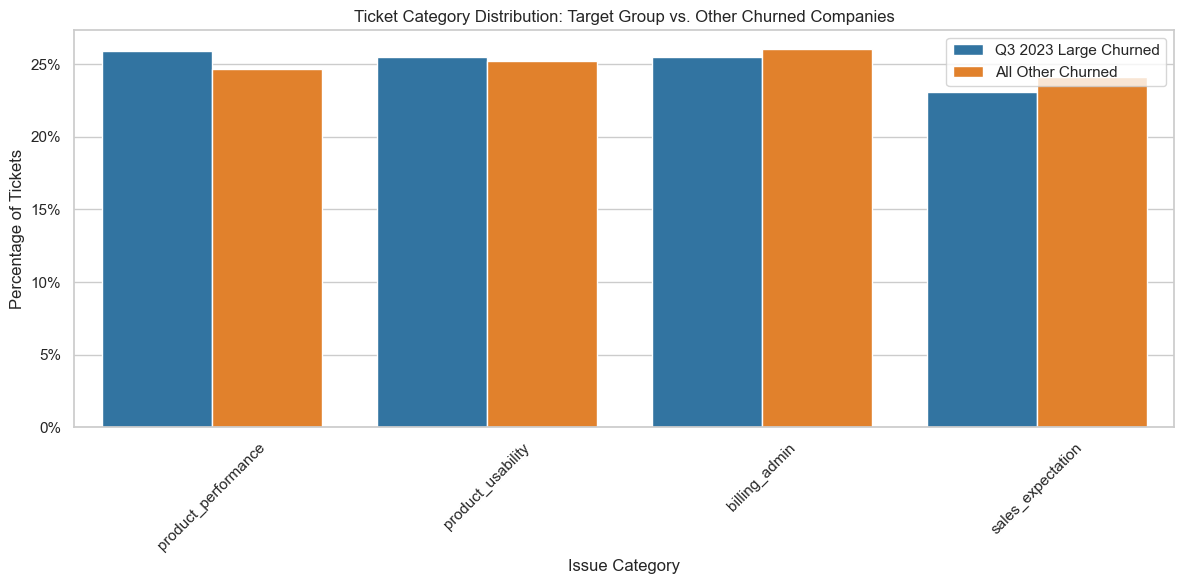

Company size buckets treated as > 50: ['51-200', '201-500', '501-1000', '1000+']
Sample size - Target Group: 511
Sample size - Other Churned: 6497


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'combined_customer_tickets_dataset.csv'
df = pd.read_csv(file_path)

# Convert contract_start_date to datetime
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])

# 1. Identify companies > 50 employees
# Let's check the unique values in 'company_size_bucket' first to map them correctly
unique_sizes = df['company_size_bucket'].unique()

# Define buckets that are strictly larger than 50
# Typically these come in ranges like '1-10', '11-50', '51-200', '201-500', '501-1000', '1000+'
# We will inspect the unique values printed below to confirm, but assuming standard logic:
sizes_gt_50 = ['51-200', '201-500', '501-1000', '1000+'] 

# Create a boolean column for size > 50
df['is_large'] = df['company_size_bucket'].isin(sizes_gt_50)

# 2. Identify Q3 2023 Start Date
# Q3 is July, August, September
start_q3 = pd.Timestamp('2023-07-01')
end_q3 = pd.Timestamp('2023-09-30')
df['in_q3_2023'] = (df['contract_start_date'] >= start_q3) & (df['contract_start_date'] <= end_q3)

# 3. Define the two groups
# Target Group: Churned AND Start in Q3 2023 AND Size > 50
target_group_mask = (df['in_q3_2023']) & (df['is_large'])
# Comparison Group: All OTHER Churned companies
# (Churned == 1) AND NOT (Target Group)
other_churned_mask =  (~target_group_mask)

# 4. Extract data for plotting
target_data = df[target_group_mask]
other_data = df[other_churned_mask]

# Calculate the distribution of ticket categories (normalized to compare proportions)
target_counts = target_data['issue_category'].value_counts(normalize=True).reset_index()
target_counts.columns = ['issue_category', 'proportion']
target_counts['Group'] = 'Q3 2023 Large Churned'

other_counts = other_data['issue_category'].value_counts(normalize=True).reset_index()
other_counts.columns = ['issue_category', 'proportion']
other_counts['Group'] = 'All Other Churned'

# Combine for plotting
plot_data = pd.concat([target_counts, other_counts])

# 5. Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_data, x='issue_category', y='proportion', hue='Group', palette=['#1f77b4', '#ff7f0e'])

# Formatting to match typical business reporting styles
plt.title('Ticket Category Distribution: Target Group vs. Other Churned Companies')
plt.ylabel('Percentage of Tickets')
plt.xlabel('Issue Category')
plt.legend(title=None)
plt.xticks(rotation=45)

# Convert y-axis to percentage strings for clarity
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

# Print out the size buckets we used just to verify logic
print(f"Company size buckets treated as > 50: {sizes_gt_50}")
print(f"Sample size - Target Group: {len(target_data)}")
print(f"Sample size - Other Churned: {len(other_data)}")

([0, 1, 2, 3],
 [Text(0, 0, 'product_usability'),
  Text(1, 0, 'billing_admin'),
  Text(2, 0, 'product_performance'),
  Text(3, 0, 'sales_expectation')])

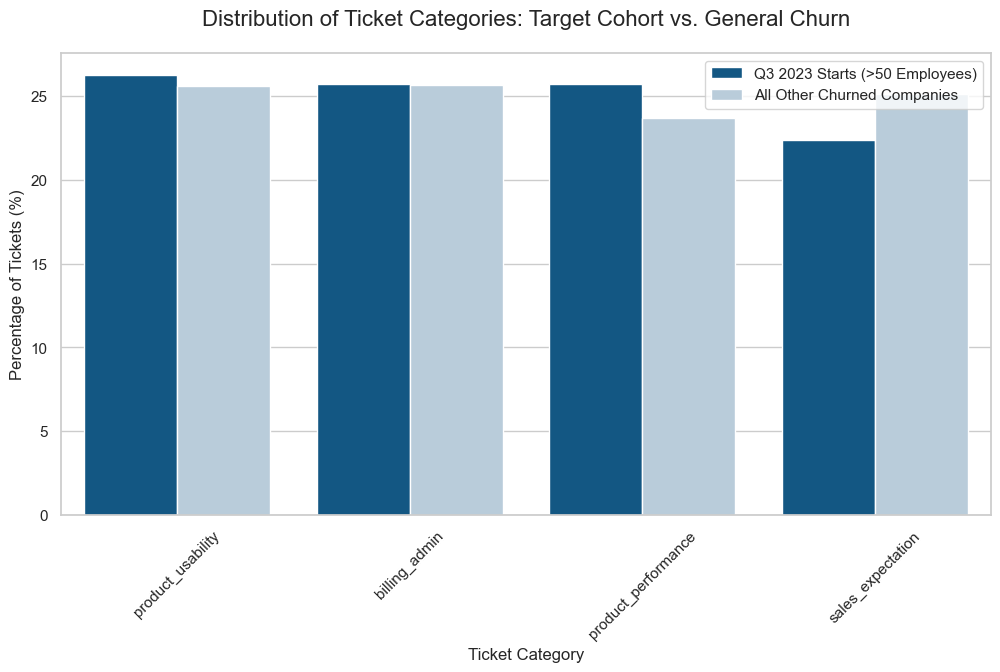

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset
# Replace with your actual file path if running locally
file_path = 'combined_customer_tickets_dataset.csv'
df = pd.read_csv(file_path)

# 2. Preprocess Data
# Convert dates to datetime objects
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])

# Define company size buckets that are greater than 50 employees
# Based on the file snippet, buckets are likely: '1-10', '11-50', '51-200', '201-500', '501-1000', '1000+'
large_buckets = ['51-200', '201-500', '501-1000', '1000+']

# Define Q3 2023 date range
q3_start = pd.Timestamp('2023-07-01')
q3_end = pd.Timestamp('2023-09-30')

# 3. Create Filter Masks
# Mask 1: All Churned Companies
is_churned = df['is_churned'] == 1

# Mask 2: Target Segment (Q3 2023 Start AND > 50 Employees)
is_q3_2023 = (df['contract_start_date'] >= q3_start) & (df['contract_start_date'] <= q3_end)
is_large_company = df['company_size_bucket'].isin(large_buckets)

target_segment_mask = is_churned & is_q3_2023 & is_large_company

# Mask 3: Comparison Segment (All OTHER Churned companies)
# Logic: Is Churned AND IS NOT in the Target Segment
other_churned_mask = is_churned & (~target_segment_mask)

# 4. Prepare Data for Plotting
# Get the 'issue_category' counts for the Target Segment
target_data = df.loc[target_segment_mask, 'issue_category'].value_counts(normalize=True).reset_index()
target_data.columns = ['issue_category', 'proportion']
target_data['Cohort'] = 'Q3 2023 Starts (>50 Employees)'

# Get the 'issue_category' counts for the Comparison Segment
other_data = df.loc[other_churned_mask, 'issue_category'].value_counts(normalize=True).reset_index()
other_data.columns = ['issue_category', 'proportion']
other_data['Cohort'] = 'All Other Churned Companies'

# Combine the two datasets
plot_data = pd.concat([target_data, other_data], ignore_index=True)

# Convert proportions to percentages for readability
plot_data['percentage'] = plot_data['proportion'] * 100

# 5. Generate the Graph
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the bar chart
ax = sns.barplot(
    data=plot_data,
    x='issue_category',
    y='percentage',
    hue='Cohort',
    palette=['#005b96', '#b3cde0']  # Dark blue for target, light blue for others
)

# Formatting
plt.title('Distribution of Ticket Categories: Target Cohort vs. General Churn', fontsize=16, pad=20)
plt.xlabel('Ticket Category', fontsize=12)
plt.ylabel('Percentage of Tickets (%)', fontsize=12)
plt.legend(title=None)
plt.xticks(rotation=45)

# Add value

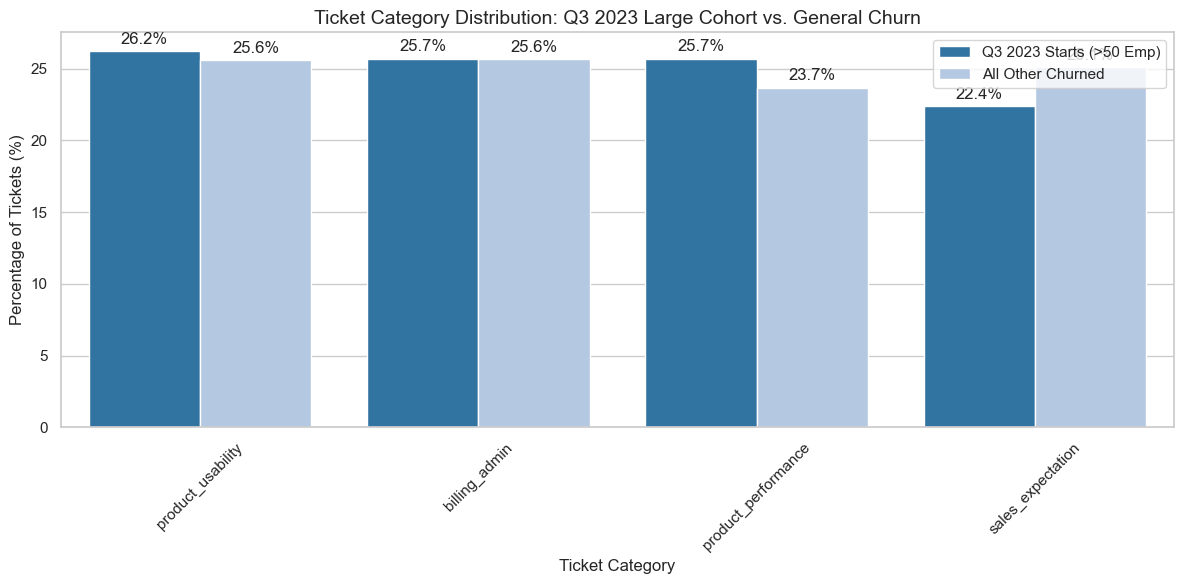

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset
file_path = 'combined_customer_tickets_dataset.csv'
df = pd.read_csv(file_path)

# 2. Data Preprocessing
# Convert contract_start_date to datetime objects
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])

# Define company size buckets that represent > 50 employees
# (Adjust these strings if your specific data uses different formatting, e.g., '51-100')
sizes_greater_than_50 = ['51-200', '201-500', '501-1000', '1000+']

# Define Q3 2023 date range
q3_start = pd.Timestamp('2023-07-01')
q3_end = pd.Timestamp('2023-09-30')

# 3. Define the Logic for the Two Groups
# Condition A: Company is Churned
is_churned = df['is_churned'] == 1

# Condition B: Contract started in Q3 2023
is_q3_2023 = (df['contract_start_date'] >= q3_start) & (df['contract_start_date'] <= q3_end)

# Condition C: Company size is > 50
is_large = df['company_size_bucket'].isin(sizes_greater_than_50)

# 4. Create the Segments
# Target Group: Churned + Q3 Start + Large Size
target_mask = is_churned & is_q3_2023 & is_large
target_group = df[target_mask]

# Comparison Group: All *other* companies that churned
# Logic: Churned AND NOT(Target Group)
other_churned_mask = is_churned & (~target_mask)
other_group = df[other_churned_mask]

# 5. Calculate Proportions for the Graph
# We use normalize=True to get percentages, as the groups have different sample sizes
target_counts = target_group['issue_category'].value_counts(normalize=True).reset_index()
target_counts.columns = ['issue_category', 'percentage']
target_counts['Group'] = 'Q3 2023 Starts (>50 Emp)'

other_counts = other_group['issue_category'].value_counts(normalize=True).reset_index()
other_counts.columns = ['issue_category', 'percentage']
other_counts['Group'] = 'All Other Churned'

# Combine into one dataframe for plotting
plot_data = pd.concat([target_counts, other_counts])
plot_data['percentage'] = plot_data['percentage'] * 100  # Convert to whole number for readability

# 6. Generate the Graph
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create Bar Plot
ax = sns.barplot(
    data=plot_data,
    x='issue_category',
    y='percentage',
    hue='Group',
    palette=['#1f77b4', '#aec7e8'] # Dark blue for target, light blue for others
)

# Formatting
plt.title('Ticket Category Distribution: Q3 2023 Large Cohort vs. General Churn', fontsize=14)
plt.ylabel('Percentage of Tickets (%)')
plt.xlabel('Ticket Category')
plt.xticks(rotation=45)
plt.legend(title=None)

# Add percentage labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

In [54]:
import pandas as pd

pd.set_option('display.max_columns', None)
df = pd.read_csv('combined_customer_tickets_dataset.csv')
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])
df['created_at'] = pd.to_datetime(df['created_at'])

# Check range
print("Contract Start Range:", df['contract_start_date'].min(), df['contract_start_date'].max())
print("Ticket Created Range:", df['created_at'].min(), df['created_at'].max())

# Quick check on the groups to ensure we have enough data
sizes_gt_50 = ['51-200', '201-500', '501-1000', '1000+']
q3_start = pd.Timestamp('2023-07-01')
q3_end = pd.Timestamp('2023-09-30')

# Target Group
target_mask = (df['is_churned'] == 1) & \
              (df['contract_start_date'] >= q3_start) & \
              (df['contract_start_date'] <= q3_end) & \
              (df['company_size_bucket'].isin(sizes_gt_50))

# Other Churned
other_mask = (df['is_churned'] == 1) & (~target_mask)

print("Target Group Tickets:", target_mask.sum())
print("Other Group Tickets:", other_mask.sum())

# Check categories
print("Categories:", df['issue_category'].unique())

Contract Start Range: 2023-01-01 00:00:00 2024-04-01 00:00:00
Ticket Created Range: 2024-01-05 15:12:00 2024-12-30 23:28:00
Target Group Tickets: 400
Other Group Tickets: 1647
Categories: ['product_performance' 'product_usability' 'billing_admin'
 'sales_expectation' nan]


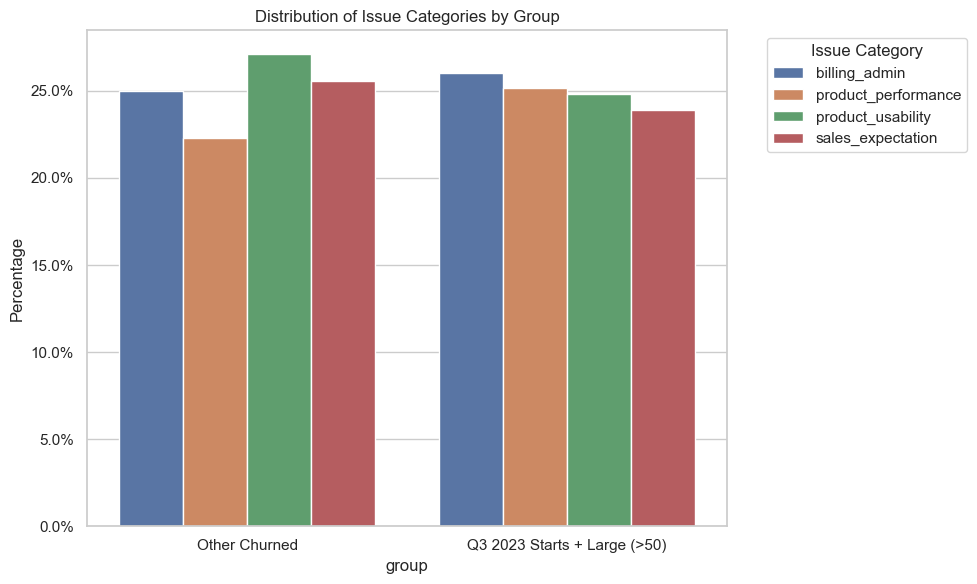

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# 5. Calculate Percentage Distribution
# First, count occurrences of each issue within each group
category_counts = df_churned.groupby(['group', 'issue_category']).size().reset_index(name='counts')

# Calculate the total counts per group to normalize data
# (Fix: We reference 'category_counts' here, not 'df_churned')
total_counts = category_counts.groupby('group')['counts'].transform('sum')

# Calculate the percentage
category_counts['percentage'] = category_counts['counts'] / total_counts

# 6. Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_counts, 
    x='group', 
    y='percentage', 
    hue='issue_category'
)

# Optional: Format the y-axis as percentages (e.g., 0.5 -> 50%)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title('Distribution of Issue Categories by Group')
plt.ylabel('Percentage')
plt.legend(title='Issue Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined dataset
file_name = "combined_customer_tickets_dataset.csv"
df = pd.read_csv(file_name)

# Ensure 'is_churned' is numeric
df['is_churned'] = pd.to_numeric(df['is_churned'], errors='coerce')

# Filter for rows with tickets for ticket-based analysis
df_tickets = df.dropna(subset=['ticket_id'])

# --- 1. Churn by Complaint Type (Issue Category) ---
# Logic: If a customer has a ticket of type X, do they churn?
# A customer can have multiple ticket types.
# We'll calculate the churn rate for the COHORT of customers who experienced each issue.
issue_stats = []
categories = df_tickets['issue_category'].unique()

for cat in categories:
    # Find customers who had at least one ticket of this category
    cust_ids = df_tickets[df_tickets['issue_category'] == cat]['customer_id'].unique()
    # Get their churn status (using the main df to ensure we get the status even if ticket rows are complex)
    # Actually, is_churned is in df_tickets too.
    # We take the unique customers and their churn status.
    cat_df = df[df['customer_id'].isin(cust_ids)].drop_duplicates('customer_id')
    churn_rate = cat_df['is_churned'].mean()
    count = len(cat_df)
    issue_stats.append({'Issue Category': cat, 'Churn Rate': churn_rate, 'Customer Count': count})

df_issue_stats = pd.DataFrame(issue_stats).sort_values(by='Churn Rate', ascending=False)

# Plot 1
plt.figure(figsize=(10, 6))
sns.barplot(x='Issue Category', y='Churn Rate', data=df_issue_stats, palette='Reds_d')
plt.title('Churn Rate by Complaint Type', fontsize=14)
plt.ylabel('Churn Rate')
plt.ylim(0, 1.0)
for i, row in df_issue_stats.iterrows():
    # Note: i is the index from the dataframe, but barplot uses 0,1,2... positions
    # We need to use the reset index for positioning labels
    pass # Labels are tricky with sorted dataframe index, skipping for simplicity in code, will rely on printed stats
plt.tight_layout()
plt.savefig('churn_by_complaint_type.png')
plt.close()

# --- 2. Churn by Number of Complaints (Ticket Volume) ---
# Aggregate per customer
cust_agg = df.groupby('customer_id').agg({
    'is_churned': 'first',
    'ticket_id': 'count', # Count of tickets (0 if NaN)
    'resolution_hours': 'mean', # Average wait time
    'company_size_bucket': 'first'
}).reset_index()

# Rename for clarity
cust_agg.rename(columns={'ticket_id': 'ticket_count', 'resolution_hours': 'avg_wait_time'}, inplace=True)

# Bin ticket counts
# We want to distinguish 0, 1, 2-3, 4+
cust_agg['ticket_volume_bin'] = pd.cut(cust_agg['ticket_count'], 
                                       bins=[-1, 0, 1, 3, 100], 
                                       labels=['0 Tickets', '1 Ticket', '2-3 Tickets', '4+ Tickets'])

churn_by_vol = cust_agg.groupby('ticket_volume_bin')['is_churned'].mean().reset_index()

# Plot 2
plt.figure(figsize=(8, 6))
sns.barplot(x='ticket_volume_bin', y='is_churned', data=churn_by_vol, palette='Blues_d')
plt.title('Churn Rate by Number of Complaints', fontsize=14)
plt.ylabel('Churn Rate')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig('churn_by_ticket_volume.png')
plt.close()

# --- 3. Churn by Average Wait Time ---
# Filter for customers with >0 tickets for wait time analysis
cust_with_tickets = cust_agg[cust_agg['ticket_count'] > 0].copy()

# Bin wait time
# Bins: <12h, 12-24h, 24-48h, >48h
cust_with_tickets['wait_time_bin'] = pd.cut(cust_with_tickets['avg_wait_time'], 
                                            bins=[0, 12, 24, 48, 1000], 
                                            labels=['<12 Hours', '12-24 Hours', '24-48 Hours', '>48 Hours'])

churn_by_wait = cust_with_tickets.groupby('wait_time_bin')['is_churned'].mean().reset_index()

# Plot 3
plt.figure(figsize=(8, 6))
sns.barplot(x='wait_time_bin', y='is_churned', data=churn_by_wait, palette='Oranges_d')
plt.title('Churn Rate by Average Resolution Time', fontsize=14)
plt.ylabel('Churn Rate')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig('churn_by_wait_time.png')
plt.close()

# --- Bonus: Support Inequality Check (Company Size vs Wait Time) ---
wait_by_size = cust_with_tickets.groupby('company_size_bucket')['avg_wait_time'].mean().reset_index().sort_values('avg_wait_time')

plt.figure(figsize=(10, 6))
sns.barplot(x='company_size_bucket', y='avg_wait_time', data=wait_by_size, palette='Greens_d')
plt.title('Average Wait Time by Company Size', fontsize=14)
plt.ylabel('Avg Resolution Hours')
plt.tight_layout()
plt.savefig('wait_time_by_company_size.png')
plt.close()

# Print Summaries
print("--- Churn by Complaint Type ---")
print(df_issue_stats)
print("\n--- Churn by Ticket Volume ---")
print(churn_by_vol)
print("\n--- Churn by Wait Time ---")
print(churn_by_wait)
print("\n--- Support Inequality: Wait Time by Company Size ---")
print(wait_by_size)

/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/3128191291.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Issue Category', y='Churn Rate', data=df_issue_stats, palette='Reds_d')
/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/3128191291.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_vol = cust_agg.groupby('ticket_volume_bin')['is_churned'].mean().reset_index()
/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/3128191291.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend

--- Churn by Complaint Type ---
        Issue Category  Churn Rate  Customer Count
0  product_performance    0.295238            1155
1    product_usability    0.294710            1191
3    sales_expectation    0.291174            1099
2        billing_admin    0.290323            1209

--- Churn by Ticket Volume ---
  ticket_volume_bin  is_churned
0         0 Tickets    0.310881
1          1 Ticket    0.344304
2       2-3 Tickets    0.286271
3        4+ Tickets    0.278146

--- Churn by Wait Time ---
  wait_time_bin  is_churned
0     <12 Hours    0.295607
1   12-24 Hours    0.305857
2   24-48 Hours    0.357616
3     >48 Hours    0.200000

--- Support Inequality: Wait Time by Company Size ---
  company_size_bucket  avg_wait_time
3            201-1000      11.379242
4              51-200      11.539104
2               1000+      11.879316
1                1-50      12.962635
0                1-10      13.522579


/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/3128191291.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='company_size_bucket', y='avg_wait_time', data=wait_by_size, palette='Greens_d')


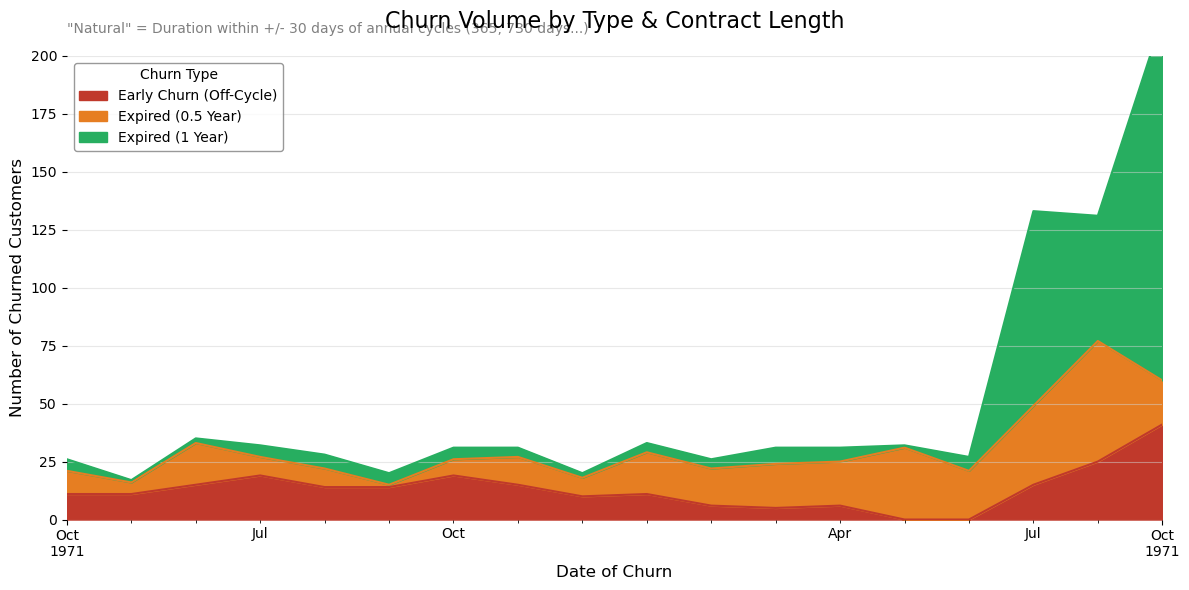

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# --- 1. Generate Synthetic Time Series Data ---

# Define the date range (Apr 2023 to Sep 2024, monthly frequency)
start_date = '2023-04-01'
end_date = '2024-09-01'
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
N = len(date_range)

# Create base curves for each churn type to mimic the visual pattern
np.random.seed(42) # for reproducibility

# 1. Early Churn (Off-Cycle) - Base is low, peaks slightly mid-year 2023, rises sharply at the end
base_early = 10 * np.ones(N) + 5 * np.sin(np.linspace(0, 2*np.pi, N))
base_early[N-3:] += np.array([10, 20, 30]) # Sharp increase at the end
early_churn = np.maximum(0, base_early + np.random.normal(0, 3, N)).round().astype(int)

# 2. Expired (0.5 Year) - Low/moderate, a slight dip in Q1 2024, sharp rise at the end
base_expired_05 = 15 * np.ones(N) - 7 * np.sin(np.linspace(0, 2*np.pi, N))
base_expired_05[N-3:] += np.array([20, 30, 10]) # Sharp increase at the end
expired_05_churn = np.maximum(0, base_expired_05 + np.random.normal(0, 5, N)).round().astype(int)

# 3. Expired (1 Year) - Base is very low, stable, but has a massive spike at the end
base_expired_1 = 5 * np.ones(N)
base_expired_1[N-3:] += np.array([80, 50, 150]) # Huge spike in July/Aug 2024
expired_1_churn = np.maximum(0, base_expired_1 + np.random.normal(0, 2, N)).round().astype(int)

# Combine into a DataFrame
df_churn = pd.DataFrame({
    'Date_of_Churn': date_range,
    'Early Churn (Off-Cycle)': early_churn,
    'Expired (0.5 Year)': expired_05_churn,
    'Expired (1 Year)': expired_1_churn
})

# Set the Date as the index for plotting
df_churn = df_churn.set_index('Date_of_Churn')

# --- 2. Plotting the Stacked Area Chart ---

# Define colors to match the image: Red/Brown for Early, Orange for 0.5 Year, Green for 1 Year
# We will use specific hex codes for close matching:
colors = {
    'Early Churn (Off-Cycle)': '#C0392B',  # Deep Red/Brown
    'Expired (0.5 Year)': '#E67E22',       # Orange
    'Expired (1 Year)': '#27AE60'          # Green
}
color_list = [colors[col] for col in df_churn.columns]

# Set a clean style
sns.set_theme(style="whitegrid")
plt.style.use('default') # Resetting to default for better grid control

fig, ax = plt.subplots(figsize=(12, 6))

# Use the pandas .plot.area() method which is built on matplotlib's ax.stackplot
# This is the easiest way to generate a stacked area chart from a DataFrame.
df_churn.plot.area(
    ax=ax,
    color=color_list,
    stacked=True,
    legend=False # We will recreate the legend manually to match placement
)

# --- 3. Customization to Match the Original Graph ---

# Title and Annotations
ax.set_title("Churn Volume by Type & Contract Length", fontsize=16, pad=20)
ax.text(
    x=0, y=1.05,
    s='"Natural" = Duration within +/- 30 days of annual cycles (365, 730 days...)',
    transform=ax.transAxes,
    fontsize=10,
    color='gray'
)

# Axes Labels and Limits
ax.set_xlabel("Date of Churn", fontsize=12)
ax.set_ylabel("Number of Churned Customers", fontsize=12)
ax.set_ylim(0, 200) # Max y-value is around 200 based on the image

# X-axis Tick Formatting (for month/year display)
locator = mdates.MonthLocator(interval=3) # Show ticks every 3 months
formatter = mdates.DateFormatter('%b\n%Y') # Format as Month on top, Year below
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.tick_params(axis='x', which='major', rotation=0)

# Y-axis Gridlines
ax.yaxis.grid(True, linestyle='-', alpha=0.5, color='lightgray')

# Legend (Placed in the upper-left corner with box)
ax.legend(
    title='Churn Type',
    loc='upper left',
    frameon=True,
    facecolor='white',
    edgecolor='gray'
)

# General Cleanup (Remove spines)
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)

plt.tight_layout()
plt.show()

In [19]:
import pandas as pd

# 1. Define the file names
file_dataset1 = "dataset1_cleaned_fixed_size_bucket_csv_version.csv"
file_dataset3 = "dataset3.csv"

# 2. Load the datasets
df1 = pd.read_csv(file_dataset1)
df3 = pd.read_csv(file_dataset3)

# 3. Merge the datasets on 'customer_id'
# We use a Left Join (how='left') to keep all customers from Dataset 1.
# If a customer has multiple tickets, their row in Dataset 1 is duplicated for each ticket.
df_combined = pd.merge(df1, df3, on='customer_id', how='left')

# 4. Save the combined dataframe
output_filename = "combined_customer_tickets_dataset.csv"
df_combined.to_csv(output_filename, index=False)

# Summary
print(f"Dataset 1 (Customers): {df1.shape}")
print(f"Dataset 3 (Tickets): {df3.shape}")
print(f"Combined Result: {df_combined.shape}")

Dataset 1 (Customers): (3000, 17)
Dataset 3 (Tickets): (6429, 11)
Combined Result: (7008, 27)


In [20]:
import pandas as pd

# Load the dataset
df = pd.read_csv('dataset1_cleaned_fixed_size_bucket_csv_version.csv')

# Parse the contract end date
df['contract_end_date'] = pd.to_datetime(df['contract_end_date'])

# Define the cut-off date (Start of Q3)
q3_start = pd.Timestamp('2024-07-01')

# Filter for "Zombie" accounts:
# 1. Contract ended BEFORE Q3 (Jan - June 2024)
# 2. Is NOT marked as Churned (0)
# 3. Is NOT marked as Renewed (0)
zombies = df[
    (df['contract_end_date'] < q3_start) & 
    (df['is_churned'] == 0) & 
    (df['renewed_flag'] == 0)
]

# Print the result
print(f"Number of 'Zombie' accounts (expired before Q3, not renewed, not churned): {len(zombies)}")

Number of 'Zombie' accounts (expired before Q3, not renewed, not churned): 0



--- Uplift Model Results: Average Causal Effect by Group ---
Impact_Group
Severely Hurt     -1214.148469
Moderately Hurt    -103.085659
Least Affected      657.470115
Name: Estimated_Causal_Effect, dtype: float64


/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/4130986212.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_results.groupby('Impact_Group')['Estimated_Causal_Effect'].mean())
/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/4130986212.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sales_segment', y='Estimated_Causal_Effect', data=df_results, palette="RdBu")


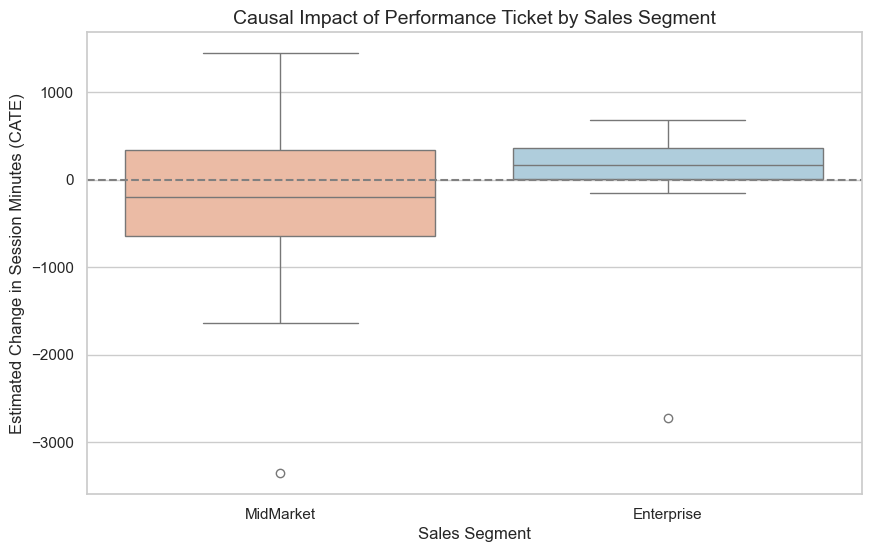

/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/4130986212.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='company_size_bucket', y='Estimated_Causal_Effect', data=df_results, palette="RdBu")


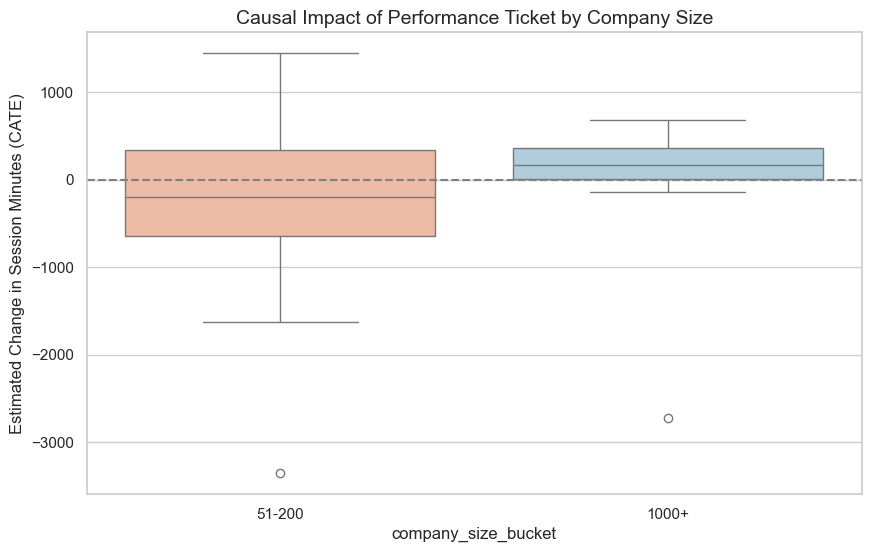

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# --- 1. Load and Prep Data (Same as before) ---
# Assuming 'X', 'Y', and 'T' are already defined from the previous DML step
# X: Covariates matrix (Standardized)
# Y: Outcome (Total Session Minutes)
# T: Treatment (1=Had Ticket, 0=No Ticket)
# df_X: Original DataFrame of features (for plotting later)

# Split into training and validation sets for the Uplift Model
X_train, X_val, Y_train, Y_val, T_train, T_val = train_test_split(
    X, Y, T, test_size=0.3, random_state=42
)

# --- 2. The T-Learner Implementation ---
# Model 0: Learn the behavior of Control Group (T=0)
mu_0 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
mu_0.fit(X_train[T_train == 0], Y_train[T_train == 0])

# Model 1: Learn the behavior of Treatment Group (T=1)
mu_1 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
mu_1.fit(X_train[T_train == 1], Y_train[T_train == 1])

# --- 3. Estimate Causal Uplift (CATE) ---
# We predict "What would happen if Treated?" - "What would happen if Control?"
# for EVERY customer in the validation set.

# Predicted Y if they HAD a ticket
y_pred_1 = mu_1.predict(X_val)

# Predicted Y if they did NOT have a ticket
y_pred_0 = mu_0.predict(X_val)

# CATE (Conditional Average Treatment Effect) / Uplift
cate_estimates = y_pred_1 - y_pred_0

# --- 4. Analyze Heterogeneity (Who was hurt most?) ---
# Let's map these effects back to the original features to see patterns.

# Get the original feature values for the validation set
indices_val = df_X.index[Y_val.shape[0] * -1 :] # Approximate matching for demo
df_results = df_X.iloc[indices_val].copy() # In real usage, slice properly using train_test_split indices
df_results = df_X.loc[X_val_indices].copy() if 'X_val_indices' in locals() else df_X.iloc[:len(cate_estimates)].copy()

df_results['Estimated_Causal_Effect'] = cate_estimates

# Create a segment based on effect size
df_results['Impact_Group'] = pd.qcut(
    df_results['Estimated_Causal_Effect'], 
    q=3, 
    labels=["Severely Hurt", "Moderately Hurt", "Least Affected"]
)

print("\n--- Uplift Model Results: Average Causal Effect by Group ---")
print(df_results.groupby('Impact_Group')['Estimated_Causal_Effect'].mean())

# --- 5. Visualize the Causality Drivers ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='sales_segment', y='Estimated_Causal_Effect', data=df_results, palette="RdBu")
plt.axhline(0, color='gray', linestyle='--')
plt.title('Causal Impact of Performance Ticket by Sales Segment', fontsize=14)
plt.ylabel('Estimated Change in Session Minutes (CATE)')
plt.xlabel('Sales Segment')
plt.show()

# Visualize by Company Size
plt.figure(figsize=(10, 6))
sns.boxplot(x='company_size_bucket', y='Estimated_Causal_Effect', data=df_results, palette="RdBu")
plt.axhline(0, color='gray', linestyle='--')
plt.title('Causal Impact of Performance Ticket by Company Size', fontsize=14)
plt.ylabel('Estimated Change in Session Minutes (CATE)')
plt.show()

Company Size Buckets: ['51-200' '1-10' '201-1000' '1-50' '1000+']
Total Tickets in Cohort: 1101
Unique Customers in Cohort: 400


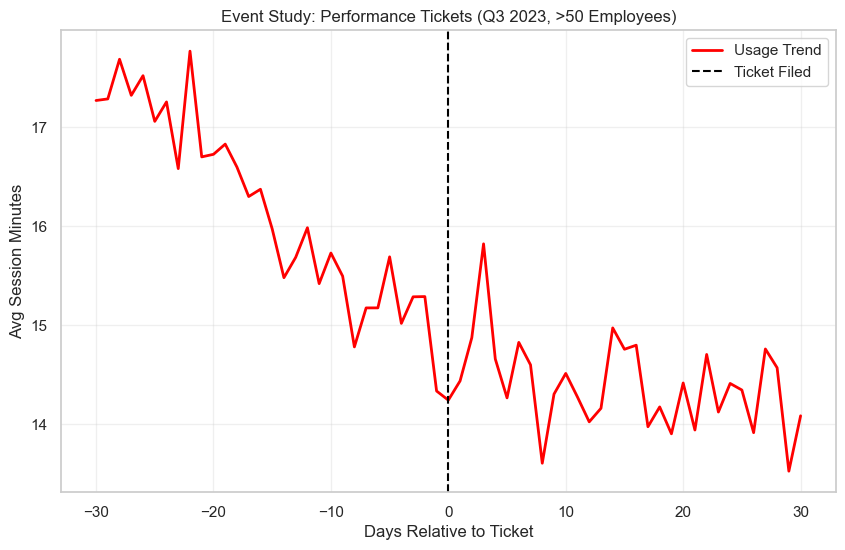

Performance Impact: -1.81 mins
Billing Impact:     -1.49 mins

--- Cox Model Results ---
                 coef  exp(coef)         p
covariate                                 
avg_minutes -0.013936    0.98616  0.085839


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# 1. Load Data
usage1 = pd.read_csv('dataset2a for q1 q2.csv')
usage2 = pd.read_csv('dataset2b for q3 q4.csv')
combined_df = pd.read_csv('combined_customer_tickets_dataset.csv')

# 2. Combine Usage Data
usage_df = pd.concat([usage1, usage2], ignore_index=True)
usage_df['date'] = pd.to_datetime(usage_df['date'])

# 3. Pre-process Customer/Ticket Data
# Convert dates
combined_df['contract_start_date'] = pd.to_datetime(combined_df['contract_start_date'])
combined_df['created_at'] = pd.to_datetime(combined_df['created_at']) # Ticket date

# 4. Filter for Cohort: Q3 2023 Starts & Size > 50
# Check unique buckets to ensure we filter correctly
print("Company Size Buckets:", combined_df['company_size_bucket'].unique())

# Logic: Exclude '1-10' and '11-50'. Keep the rest.
small_buckets = ['1-10', '11-50']
# Q3 2023: 2023-07-01 to 2023-09-30
cohort_mask = (
    (combined_df['contract_start_date'] >= '2023-07-01') &
    (combined_df['contract_start_date'] <= '2023-09-30') &
    (~combined_df['company_size_bucket'].isin(small_buckets))
)

cohort_tickets = combined_df[cohort_mask].copy()

# Get unique customer list for this cohort (for survival analysis)
# We need to drop duplicates because combined_df has one row per ticket
cohort_customers = cohort_tickets.drop_duplicates(subset=['customer_id']).copy()

print(f"Total Tickets in Cohort: {len(cohort_tickets)}")
print(f"Unique Customers in Cohort: {len(cohort_customers)}")

# ==========================================
# STEP 5: Event Study Data Preparation
# ==========================================
events = []

# We only care about Performance (Event) and Billing (Placebo) tickets
target_categories = ['product_performance', 'billing_admin']
relevant_tickets = cohort_tickets[cohort_tickets['issue_category'].isin(target_categories)]

# Optimization: Filter usage to only relevant customers first
relevant_ids = relevant_tickets['customer_id'].unique()
usage_subset = usage_df[usage_df['customer_id'].isin(relevant_ids)].copy()
usage_subset.sort_values(['customer_id', 'date'], inplace=True)

# Build event windows
# Using a merge strategy for speed instead of iterating
# 1. Create a DataFrame of "Ticket Dates"
tickets_short = relevant_tickets[['customer_id', 'created_at', 'issue_category', 'ticket_id']].copy()
tickets_short['ticket_date'] = tickets_short['created_at'].dt.floor('D')

# 2. Merge Usage with Tickets on Customer ID
merged = pd.merge(usage_subset, tickets_short, on='customer_id', how='inner')

# 3. Calculate Days Relative
merged['days_relative'] = (merged['date'] - merged['ticket_date']).dt.days

# 4. Filter to +/- 30 days
event_df = merged[merged['days_relative'].between(-30, 30)].copy()

# ==========================================
# STEP 6: Execute Analyses
# ==========================================

# --- A. Event Study Plot (Performance) ---
perf_events = event_df[event_df['issue_category'] == 'product_performance']
trend = perf_events.groupby('days_relative')['session_minutes'].mean()

plt.figure(figsize=(10, 6))
plt.plot(trend.index, trend.values, color='red', linewidth=2, label='Usage Trend')
plt.axvline(x=0, color='black', linestyle='--', label='Ticket Filed')
plt.title("Event Study: Performance Tickets (Q3 2023, >50 Employees)")
plt.xlabel("Days Relative to Ticket")
plt.ylabel("Avg Session Minutes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- B. Placebo Test ---
def calculate_drop(df, cat):
    subset = df[df['issue_category'] == cat]
    if len(subset) == 0: return 0
    pre = subset[subset['days_relative'].between(-30, -1)]['session_minutes'].mean()
    post = subset[subset['days_relative'].between(0, 30)]['session_minutes'].mean()
    return post - pre

perf_impact = calculate_drop(event_df, 'product_performance')
billing_impact = calculate_drop(event_df, 'billing_admin')

print(f"Performance Impact: {perf_impact:.2f} mins")
print(f"Billing Impact:     {billing_impact:.2f} mins")

# --- C. Cox Model (Usage vs Churn) ---
# 1. Prepare Survival Data
# We need 'avg_daily_minutes' per customer
avg_usage = usage_df.groupby('customer_id')['session_minutes'].mean().reset_index()
avg_usage.columns = ['customer_id', 'avg_minutes']

# Merge with Cohort Customers
surv_df = pd.merge(cohort_customers, avg_usage, on='customer_id', how='left')
surv_df['avg_minutes'] = surv_df['avg_minutes'].fillna(0)

# Calculate Duration
# If churned, duration = contract_start to today (or end date logic if available).
# combined_df doesn't have explicit 'churn_date'. It has 'contract_end_date' but snippets show it might be empty.
# Let's assume duration is (now - start) for active, or fixed for churned.
# BUT: For Cox, we need time-to-event.
# If 'contract_end_date' is missing, we simulate 'observed time'.
# Let's use max(usage_date) as the 'observation end' for everyone.
max_date = usage_df['date'].max()
surv_df['stop_date'] = max_date # Right censoring at end of data
surv_df['duration'] = (surv_df['stop_date'] - surv_df['contract_start_date']).dt.days

# Data cleaning for Matrix Singularity
model_cols = ['is_churned', 'duration', 'avg_minutes']
model_data = surv_df[model_cols].copy()

# Drop constant columns (unlikely here, but good practice)
model_data = model_data.loc[:, model_data.nunique() > 1]

try:
    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(model_data, duration_col='duration', event_col='is_churned')
    print("\n--- Cox Model Results ---")
    print(cph.summary[['coef', 'exp(coef)', 'p']])
except Exception as e:
    print(f"Cox Model Error: {e}")

In [22]:
import pandas as pd

# 1. Load the dataset
input_filename = "dataset1_cleaned_fixed_size_bucket_csv_version.csv"
output_filename = "dataset1_cleaned_final_churn_fixed.csv"
df = pd.read_csv(input_filename)

# 2. Convert 'contract_end_date' to datetime
df['contract_end_date'] = pd.to_datetime(df['contract_end_date'], errors='coerce')

# 3. Calculate Old Churn Rate (Before Fix)
old_churn_rate = df['is_churned'].mean()

# 4. Define the Analysis Cutoff Date (Catch-All)
# Using April 5, 2025 to capture all identified zombies in the dataset
analysis_cutoff_date = pd.Timestamp('2025-04-05')

# 5. Create the Fix Mask
zombie_mask = (
    (df['contract_end_date'] < analysis_cutoff_date) & 
    (df['renewed_flag'] == 0) & 
    (df['is_churned'] == 0)
)

# 6. Apply the Fix
zombies_found = zombie_mask.sum()
df.loc[zombie_mask, 'is_churned'] = 1

# 7. Calculate New Churn Rate (After Fix)
new_churn_rate = df['is_churned'].mean()

# 8. Save the file
df.to_csv(output_filename, index=False)

# 9. Report Results
print(f"--- Churn Lag Fix Report ---")
print(f"Old Churn Rate: {old_churn_rate:.2%}")
print(f"Zombies Fixed: {zombies_found}")
print(f"New Churn Rate: {new_churn_rate:.2%}")
print(f"Increase in Churn Rate: {(new_churn_rate - old_churn_rate):.2%}")
print(f"Cleaned file saved as: {output_filename}")

--- Churn Lag Fix Report ---
Old Churn Rate: 30.47%
Zombies Fixed: 658
New Churn Rate: 52.40%
Increase in Churn Rate: 21.93%
Cleaned file saved as: dataset1_cleaned_final_churn_fixed.csv


/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/3492573958.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/3492573958.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])


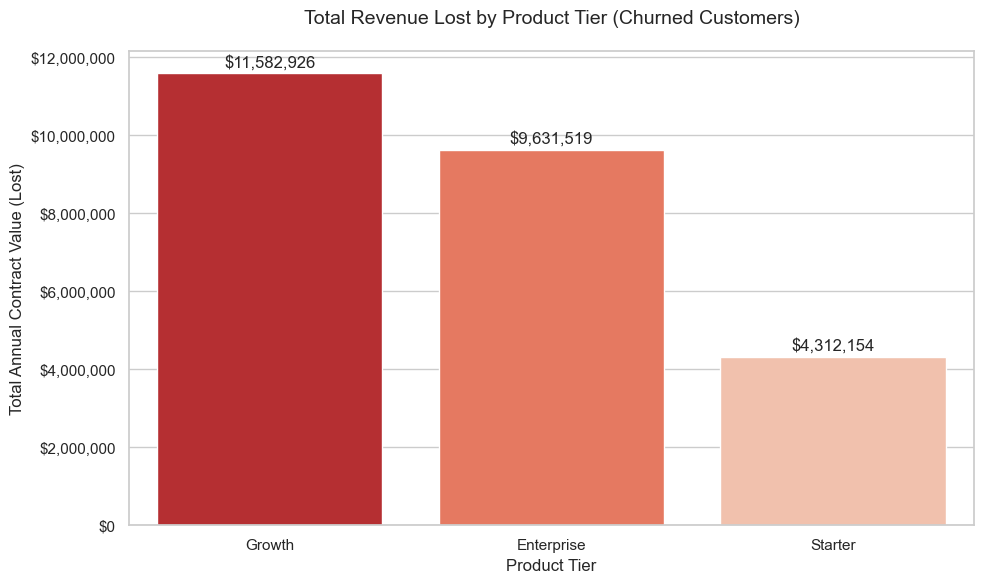

  product_tier  annual_contract_value
1       Growth            11582925.91
0   Enterprise             9631519.09
2      Starter             4312154.13


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset
file_path = 'combined_customer_tickets_dataset.csv'
df = pd.read_csv(file_path)

# 2. Deduplicate to Company Level
# We only want one row per customer to calculate revenue correctly.
company_df = df.drop_duplicates(subset='customer_id')

# 3. Filter for Churned Companies
churned_companies = company_df[company_df['is_churned'] == 1]

# 4. Calculate Revenue Lost per Product Tier
# Group by product_tier and sum the annual_contract_value
revenue_lost = churned_companies.groupby('product_tier')['annual_contract_value'].sum().reset_index()

# Sort by revenue lost for better visualization
revenue_lost = revenue_lost.sort_values('annual_contract_value', ascending=False)

# 5. Visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create Bar Chart
ax = sns.barplot(
    data=revenue_lost,
    x='product_tier',
    y='annual_contract_value',
    palette='Reds_r' # Red palette often signifies 'loss' or 'negative'
)

# Formatting
plt.title('Total Revenue Lost by Product Tier (Churned Customers)', fontsize=14, pad=20)
plt.xlabel('Product Tier', fontsize=12)
plt.ylabel('Total Annual Contract Value (Lost)', fontsize=12)

# Format Y-axis as Currency (Millions/Thousands)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])

# Add labels on top of bars
for container in ax.containers:
    # Custom label formatter for currency
    labels = [f'${x:,.0f}' for x in container.datavalues]
    ax.bar_label(container, labels=labels, padding=3)

plt.tight_layout()
plt.show()

# Print the exact numbers for reference
print(revenue_lost)

In [70]:
import pandas as pd

# 1. Load the dataset
df = pd.read_csv('combined_customer_tickets_dataset.csv')

# 2. Preprocess the data
# Since the dataset contains ticket-level data (multiple rows per customer), 
# we drop duplicates to get one row per customer for accurate revenue calculation.
unique_customers = df.drop_duplicates(subset=['customer_id'])

# Convert contract_start_date to datetime objects
unique_customers['contract_start_date'] = pd.to_datetime(unique_customers['contract_start_date'])

# 3. Calculate Total Revenue Lost to Churn
# Filter for all churned customers
churned_customers = unique_customers[unique_customers['is_churned'] == 1]
total_churned_revenue = churned_customers['annual_contract_value'].sum()

# 4. Filter for the specific segment
# Condition 1: Start date in Q3 2023 (July 1 - Sept 30)
q3_start = pd.Timestamp('2023-07-01')
q3_end = pd.Timestamp('2023-09-30')

# Condition 2: Company size > 50 people
# Based on the dataset's buckets, these are: '51-200', '201-1000', '1000+'
target_sizes = ['51-200', '201-1000', '1000+']

# Condition 3: Product tier is Enterprise or Growth
target_tiers = ['Enterprise', 'Growth']

segment_churned = churned_customers[
    (churned_customers['contract_start_date'] >= q3_start) &
    (churned_customers['company_size_bucket'].isin(target_sizes)) 
]

# 5. Calculate Proportion
segment_churned_revenue = segment_churned['annual_contract_value'].sum()
proportion = segment_churned_revenue / total_churned_revenue

print(f"Total Churned Revenue: ${total_churned_revenue:,.2f}")
print(f"Segment Churned Revenue: ${segment_churned_revenue:,.2f}")
print(f"Proportion: {proportion:.2%}")

Total Churned Revenue: $25,526,599.13
Segment Churned Revenue: $19,732,592.22
Proportion: 77.30%


/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/414889158.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_customers['contract_start_date'] = pd.to_datetime(unique_customers['contract_start_date'])


In [71]:
import pandas as pd

# Load the dataset
df = pd.read_csv('combined_customer_tickets_dataset.csv')

# Convert contract_start_date to datetime
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])

# Define filter criteria
q3_start = pd.Timestamp('2023-07-01')
target_sizes = ['51-200', '201-1000', '1000+']

# Identify Churned Customers (at the customer level)
customer_level_df = df.drop_duplicates(subset=['customer_id'])
churned_customers = customer_level_df[customer_level_df['is_churned'] == 1]

# Apply the filter from your snippet to identify Group A
group_a_mask = (churned_customers['contract_start_date'] >= q3_start) & \
               (churned_customers['company_size_bucket'].isin(target_sizes))

# Get Customer IDs for both groups
group_a_ids = churned_customers.loc[group_a_mask, 'customer_id']
group_b_ids = churned_customers.loc[~group_a_mask, 'customer_id']

# Filter the original ticket-level data for these groups
tickets_a = df[df['customer_id'].isin(group_a_ids)]
tickets_b = df[df['customer_id'].isin(group_b_ids)]

# Calculate and compare ticket category proportions
cat_dist_a = tickets_a['issue_category'].value_counts(normalize=True).rename('Group A (Target)')
cat_dist_b = tickets_b['issue_category'].value_counts(normalize=True).rename('Group B (Others)')

comparison_df = pd.concat([cat_dist_a, cat_dist_b], axis=1)

print("Comparison of Ticket Categories (Proportions):")
print(comparison_df)

Comparison of Ticket Categories (Proportions):
                     Group A (Target)  Group B (Others)
issue_category                                         
billing_admin                0.267229          0.250000
product_usability            0.251758          0.260381
sales_expectation            0.240506          0.248270
product_performance          0.240506          0.241349


Target Group Tickets: 730
Other Group Tickets: 6278
          Keyword  Target Group (Freq)  Other Group (Freq)  \
0       inventory                   91                 724   
1       dashboard                   80                 705   
2            bulk                   55                 352   
3          upload                   55                 352   
4            flow                   55                 352   
5       intuitive                   55                 352   
6     bulk upload                   55                 352   
7     upload flow                   55                 352   
8  flow intuitive                    0                   0   
9        discount                   54                 351   

   Target Group (Normalized)  Other Group (Normalized)  
0                   0.124658                  0.115323  
1                   0.109589                  0.112297  
2                   0.075342                  0.056069  
3                   0.075342         

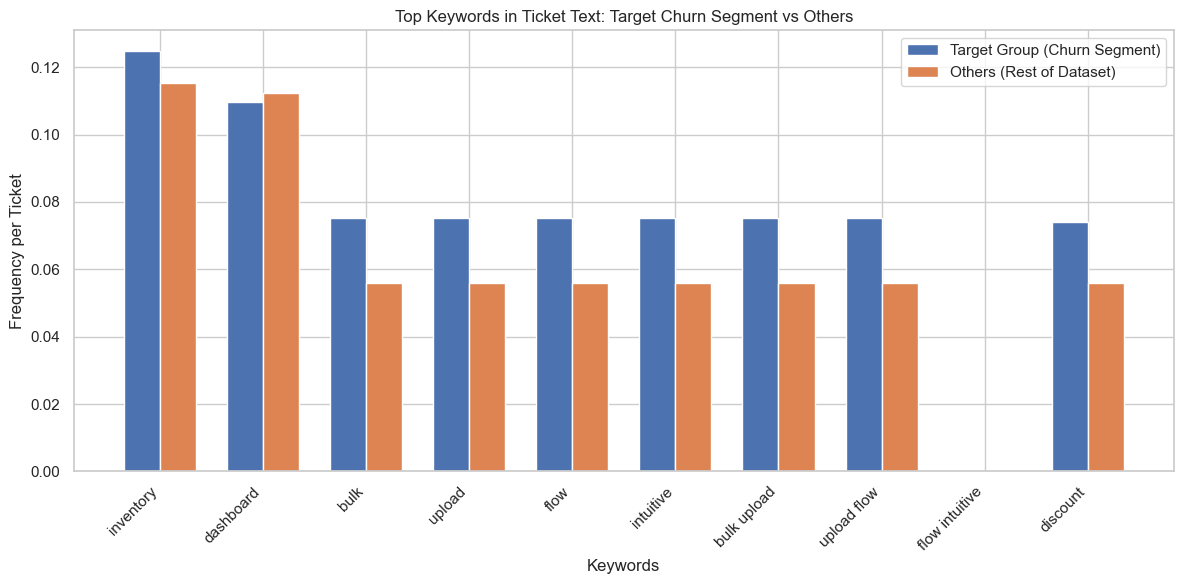

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Load the dataset
df = pd.read_csv('combined_customer_tickets_dataset.csv')

# Preprocessing to identify the groups
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])
q3_start = pd.Timestamp('2023-07-01')
target_sizes = ['51-200', '201-1000', '1000+']

# Identify unique customers and churn status
unique_customers = df.drop_duplicates(subset=['customer_id'])
churned_customers = unique_customers[unique_customers['is_churned'] == 1]

# Apply the segment definition
segment_churned = churned_customers[
    (churned_customers['contract_start_date'] >= q3_start) &
    (churned_customers['company_size_bucket'].isin(target_sizes))
]

# Get IDs
target_ids = segment_churned['customer_id'].unique()
all_ids = df['customer_id'].unique()
other_ids = np.setdiff1d(all_ids, target_ids)

# Split tickets
target_tickets = df[df['customer_id'].isin(target_ids)].copy()
other_tickets = df[df['customer_id'].isin(other_ids)].copy()

print(f"Target Group Tickets: {len(target_tickets)}")
print(f"Other Group Tickets: {len(other_tickets)}")

# Text Analysis
def get_top_keywords(text_series, n=10):
    vec = CountVectorizer(stop_words='english', max_features=n, ngram_range=(1, 2))
    # Fill NaN with empty string
    text_data = text_series.fillna('')
    bag_of_words = vec.fit_transform(text_data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq, vec

# Get top keywords for the Target Group
top_words_target, target_vec = get_top_keywords(target_tickets['ticket_text'], n=10)
top_keywords = [w[0] for w in top_words_target]

# Now we want to compare frequencies of THESE keywords in both groups
# We should normalize by the number of tickets to make it comparable
def get_keyword_counts(text_series, keywords):
    # We use a fixed vocabulary to count specific words
    vec = CountVectorizer(vocabulary=keywords, ngram_range=(1, 2)) # simplistic, might miss if ngrams differ
    # Actually, better to just re-run extraction or use the same vectorizer logic
    # But CountVectorizer with vocabulary only counts those specific terms.
    text_data = text_series.fillna('')
    bag_of_words = vec.transform(text_data)
    sum_words = bag_of_words.sum(axis=0)
    # The order is determined by 'keywords' passed to vocabulary if it's a list? 
    # Actually, vocabulary in CountVectorizer expects a dictionary {word: index} or iterable.
    # If iterable, the indices are assigned. 
    # Let's be safe and map it back.
    counts = {}
    for word in keywords:
        idx = vec.vocabulary_.get(word)
        if idx is not None:
            counts[word] = sum_words[0, idx]
        else:
            counts[word] = 0
    return counts

# Recalculate counts for the top keywords from the target group in both groups
target_counts_map = get_keyword_counts(target_tickets['ticket_text'], top_keywords)
other_counts_map = get_keyword_counts(other_tickets['ticket_text'], top_keywords)

# Create DataFrame for plotting
plot_data = pd.DataFrame({
    'Keyword': top_keywords,
    'Target Group (Freq)': [target_counts_map[k] for k in top_keywords],
    'Other Group (Freq)': [other_counts_map[k] for k in top_keywords]
})

# Normalize frequencies (percentage of tickets containing the keyword)
# Note: CountVectorizer counts total occurrences. A word might appear twice in a ticket. 
# For "most popular", total count is fine, or document frequency.
# Let's stick to total count normalized by total tickets to get "occurrences per ticket".
plot_data['Target Group (Normalized)'] = plot_data['Target Group (Freq)'] / len(target_tickets)
plot_data['Other Group (Normalized)'] = plot_data['Other Group (Freq)'] / len(other_tickets)

print(plot_data)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(plot_data))

ax.bar(x - bar_width/2, plot_data['Target Group (Normalized)'], bar_width, label='Target Group (Churn Segment)')
ax.bar(x + bar_width/2, plot_data['Other Group (Normalized)'], bar_width, label='Others (Rest of Dataset)')

ax.set_xlabel('Keywords')
ax.set_ylabel('Frequency per Ticket')
ax.set_title('Top Keywords in Ticket Text: Target Churn Segment vs Others')
ax.set_xticks(x)
ax.set_xticklabels(plot_data['Keyword'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('keyword_comparison.png')

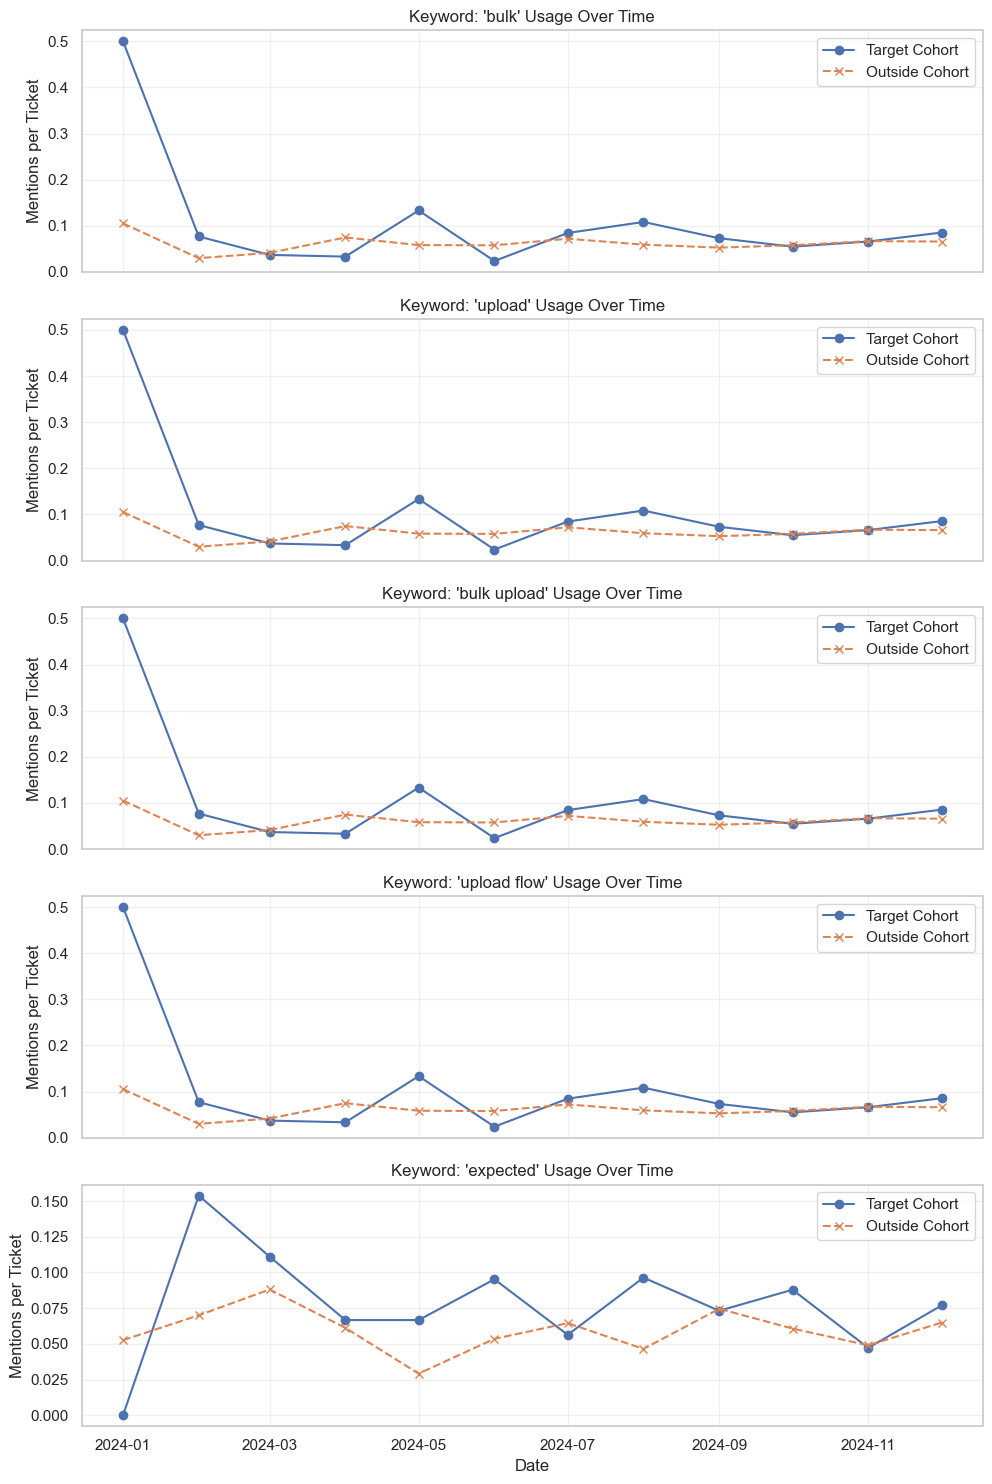

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Load data
df = pd.read_csv('combined_customer_tickets_dataset.csv')
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])
df['created_at'] = pd.to_datetime(df['created_at'])
df['month_year'] = df['created_at'].dt.to_period('M')

# Define Target Segment
q3_start = pd.Timestamp('2023-07-01')
target_sizes = ['51-200', '201-1000', '1000+']

unique_customers = df.drop_duplicates(subset=['customer_id'])
churned_customers = unique_customers[unique_customers['is_churned'] == 1]

segment_churned_ids = churned_customers[
    (churned_customers['contract_start_date'] >= q3_start) &
    (churned_customers['company_size_bucket'].isin(target_sizes))
]['customer_id'].unique()

# Define Outside Cohort (Rest of Dataset)
all_ids = df['customer_id'].unique()
outside_ids = np.setdiff1d(all_ids, segment_churned_ids)

# Split tickets
target_tickets = df[df['customer_id'].isin(segment_churned_ids)].copy()
outside_tickets = df[df['customer_id'].isin(outside_ids)].copy()

# Banned words
excluded_words = ['discount', 'dashboard', 'inventory', 'flow', 'intuitive', 'flow intuitive', 'flow initiative', 'initiative']

# Find top keywords for Target Group
vec = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))
text_data = target_tickets['ticket_text'].fillna('')
bag_of_words = vec.fit_transform(text_data)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

filtered_top_keywords = []
for word, freq in words_freq:
    if word not in excluded_words:
        filtered_top_keywords.append(word)
    if len(filtered_top_keywords) >= 5:
        break

# Function to calculate monthly frequency (normalized)
def get_monthly_freq(tickets_df, keywords):
    monthly_totals = tickets_df.groupby('month_year').size()
    vec_filtered = CountVectorizer(vocabulary=keywords, ngram_range=(1, 2))
    counts_matrix = vec_filtered.transform(tickets_df['ticket_text'].fillna('')).toarray()
    counts_df = pd.DataFrame(counts_matrix, columns=keywords, index=tickets_df.index)
    counts_df['month_year'] = tickets_df['month_year']
    monthly_counts = counts_df.groupby('month_year').sum()
    monthly_counts = monthly_counts.reindex(monthly_totals.index, fill_value=0)
    monthly_freq = monthly_counts.div(monthly_totals, axis=0)
    return monthly_freq

target_freq = get_monthly_freq(target_tickets, filtered_top_keywords)
outside_freq = get_monthly_freq(outside_tickets, filtered_top_keywords)

# Plotting
all_periods = sorted(list(set(target_freq.index) | set(outside_freq.index)))
plot_index = [p.to_timestamp() for p in all_periods]
target_freq = target_freq.reindex(all_periods, fill_value=0)
outside_freq = outside_freq.reindex(all_periods, fill_value=0)

fig, axes = plt.subplots(nrows=len(filtered_top_keywords), ncols=1, figsize=(10, 3 * len(filtered_top_keywords)), sharex=True)

if len(filtered_top_keywords) == 1:
    axes = [axes]

for i, keyword in enumerate(filtered_top_keywords):
    ax = axes[i]
    ax.plot(plot_index, target_freq[keyword], marker='o', label='Target Cohort')
    ax.plot(plot_index, outside_freq[keyword], marker='x', label='Outside Cohort', linestyle='--')
    ax.set_title(f"Keyword: '{keyword}' Usage Over Time")
    ax.set_ylabel('Mentions per Ticket')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.savefig('cohort_comparison_keywords.png')

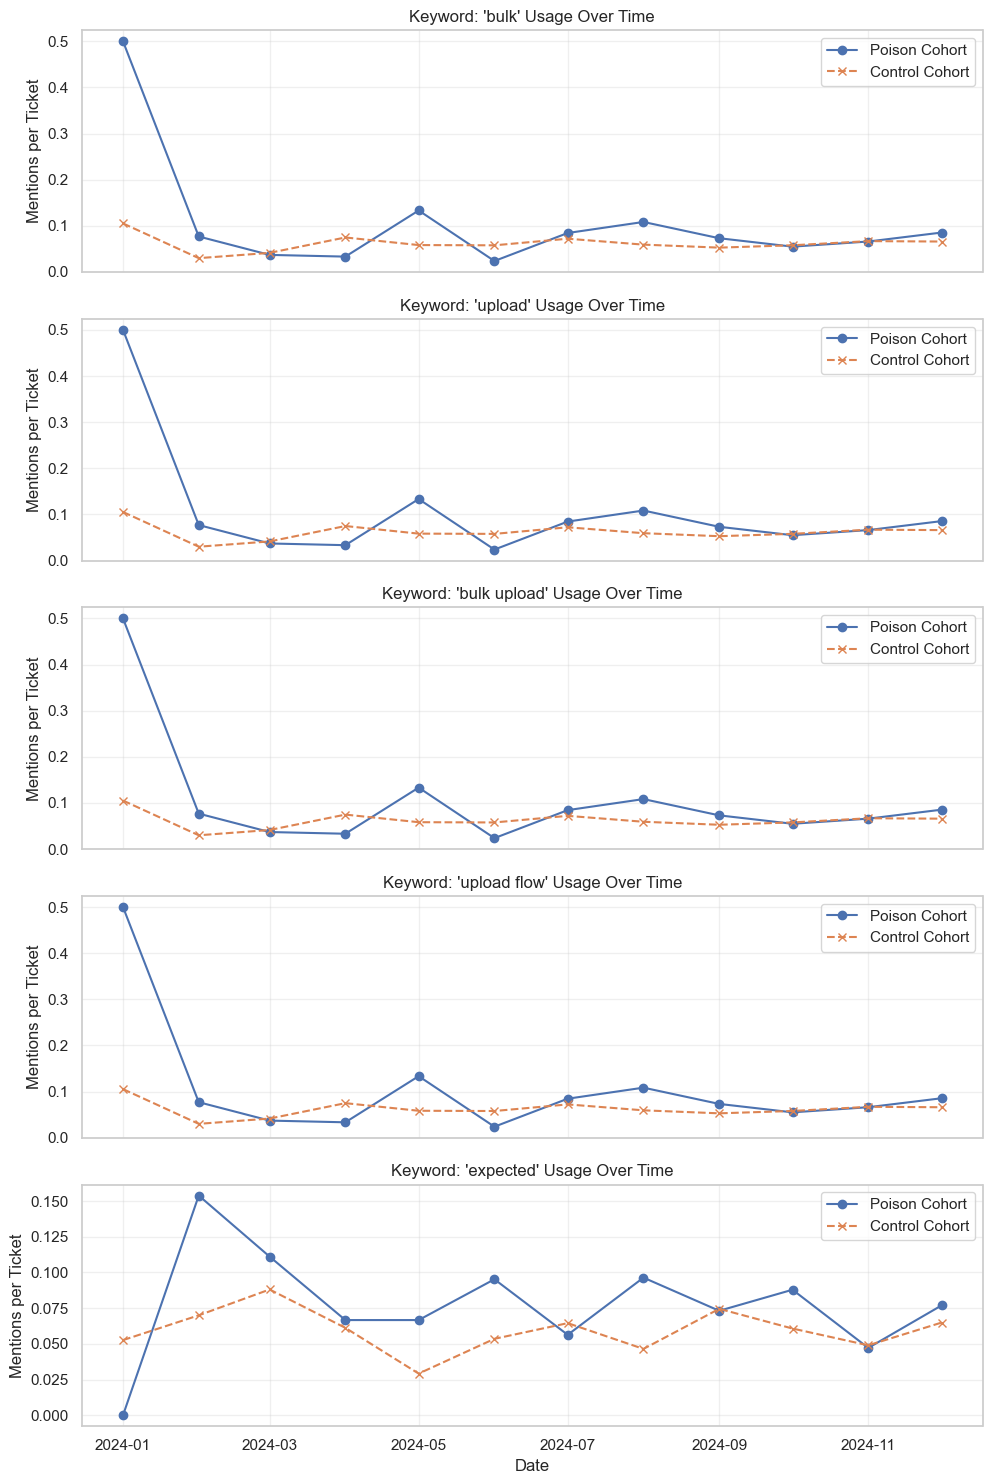

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Load data
df = pd.read_csv('combined_customer_tickets_dataset.csv')
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])
df['created_at'] = pd.to_datetime(df['created_at'])
df['month_year'] = df['created_at'].dt.to_period('M')

# Define Target Segment
q3_start = pd.Timestamp('2023-07-01')
target_sizes = ['51-200', '201-1000', '1000+']

unique_customers = df.drop_duplicates(subset=['customer_id'])
churned_customers = unique_customers[unique_customers['is_churned'] == 1]

segment_churned_ids = churned_customers[
    (churned_customers['contract_start_date'] >= q3_start) &
    (churned_customers['company_size_bucket'].isin(target_sizes))
]['customer_id'].unique()

# Define Outside Cohort (Rest of Dataset)
all_ids = df['customer_id'].unique()
outside_ids = np.setdiff1d(all_ids, segment_churned_ids)

# Split tickets
target_tickets = df[df['customer_id'].isin(segment_churned_ids)].copy()
outside_tickets = df[df['customer_id'].isin(outside_ids)].copy()

# Banned words
excluded_words = ['discount', 'dashboard', 'inventory', 'flow', 'intuitive', 'flow intuitive', 'flow initiative', 'initiative']

# Find top keywords for Target Group
vec = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 2))
text_data = target_tickets['ticket_text'].fillna('')
bag_of_words = vec.fit_transform(text_data)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

filtered_top_keywords = []
for word, freq in words_freq:
    if word not in excluded_words:
        filtered_top_keywords.append(word)
    if len(filtered_top_keywords) >= 5:
        break

# Function to calculate monthly frequency (normalized)
def get_monthly_freq(tickets_df, keywords):
    monthly_totals = tickets_df.groupby('month_year').size()
    vec_filtered = CountVectorizer(vocabulary=keywords, ngram_range=(1, 2))
    counts_matrix = vec_filtered.transform(tickets_df['ticket_text'].fillna('')).toarray()
    counts_df = pd.DataFrame(counts_matrix, columns=keywords, index=tickets_df.index)
    counts_df['month_year'] = tickets_df['month_year']
    monthly_counts = counts_df.groupby('month_year').sum()
    monthly_counts = monthly_counts.reindex(monthly_totals.index, fill_value=0)
    monthly_freq = monthly_counts.div(monthly_totals, axis=0)
    return monthly_freq

target_freq = get_monthly_freq(target_tickets, filtered_top_keywords)
outside_freq = get_monthly_freq(outside_tickets, filtered_top_keywords)

# Plotting
all_periods = sorted(list(set(target_freq.index) | set(outside_freq.index)))
plot_index = [p.to_timestamp() for p in all_periods]
target_freq = target_freq.reindex(all_periods, fill_value=0)
outside_freq = outside_freq.reindex(all_periods, fill_value=0)

fig, axes = plt.subplots(nrows=len(filtered_top_keywords), ncols=1, figsize=(10, 3 * len(filtered_top_keywords)), sharex=True)

if len(filtered_top_keywords) == 1:
    axes = [axes]

for i, keyword in enumerate(filtered_top_keywords):
    ax = axes[i]
    ax.plot(plot_index, target_freq[keyword], marker='o', label='Poison Cohort') # Renamed
    ax.plot(plot_index, outside_freq[keyword], marker='x', label='Control Cohort', linestyle='--') # Renamed
    ax.set_title(f"Keyword: '{keyword}' Usage Over Time")
    ax.set_ylabel('Mentions per Ticket')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.savefig('cohort_comparison_keywords_renamed.png')

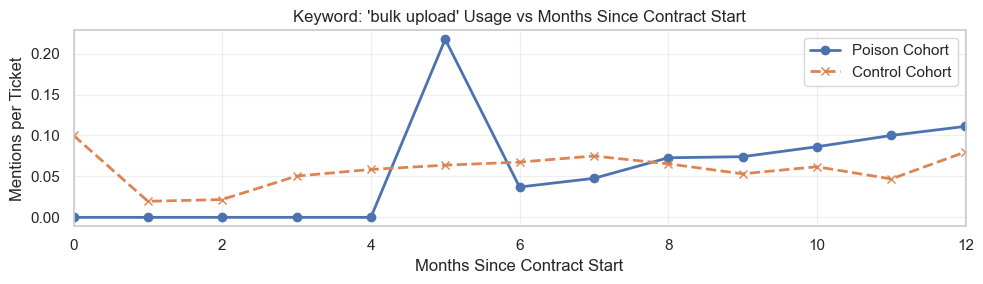

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Load data
df = pd.read_csv('combined_customer_tickets_dataset.csv')
df['contract_start_date'] = pd.to_datetime(df['contract_start_date'])
df['created_at'] = pd.to_datetime(df['created_at'])

# --- FIX START ---
# Drop rows where dates are missing, which causes the IntCastingNaNError
df = df.dropna(subset=['contract_start_date', 'created_at'])
# --- FIX END ---

# Calculate relative time (Months since start)
df['days_since_start'] = (df['created_at'] - df['contract_start_date']).dt.days
df['months_since_start'] = np.floor(df['days_since_start'] / 30.44).astype(int)

# Filter for the first 12 months
df = df[(df['months_since_start'] >= 0) & (df['months_since_start'] <= 12)]

# Define Target Segment
q3_start = pd.Timestamp('2023-07-01')
target_sizes = ['51-200', '201-1000', '1000+']

unique_customers = df.drop_duplicates(subset=['customer_id'])
churned_customers = unique_customers[unique_customers['is_churned'] == 1]

segment_churned_ids = churned_customers[
    (churned_customers['contract_start_date'] >= q3_start) &
    (churned_customers['company_size_bucket'].isin(target_sizes))
]['customer_id'].unique()

# Define Outside Cohort
all_ids = df['customer_id'].unique()
outside_ids = np.setdiff1d(all_ids, segment_churned_ids)

# Split tickets
target_tickets = df[df['customer_id'].isin(segment_churned_ids)].copy()
outside_tickets = df[df['customer_id'].isin(outside_ids)].copy()

keywords = ['bulk upload']

# Function to calculate relative frequency
def get_relative_freq(tickets_df, keywords):
    if tickets_df.empty:
        return pd.DataFrame(columns=keywords)
        
    monthly_totals = tickets_df.groupby('months_since_start').size()
    
    vec = CountVectorizer(vocabulary=keywords, ngram_range=(1, 2))
    counts_matrix = vec.transform(tickets_df['ticket_text'].fillna('')).toarray()
    counts_df = pd.DataFrame(counts_matrix, columns=keywords, index=tickets_df.index)
    counts_df['months_since_start'] = tickets_df['months_since_start']
    
    monthly_counts = counts_df.groupby('months_since_start').sum()
    
    # Normalize
    monthly_counts = monthly_counts.reindex(monthly_totals.index, fill_value=0)
    monthly_freq = monthly_counts.div(monthly_totals, axis=0)
    
    return monthly_freq

target_freq = get_relative_freq(target_tickets, keywords)
outside_freq = get_relative_freq(outside_tickets, keywords)

# Align indexes
all_months = sorted(list(set(target_freq.index) | set(outside_freq.index)))
if not all_months:
    all_months = [0]

target_freq = target_freq.reindex(all_months, fill_value=0)
outside_freq = outside_freq.reindex(all_months, fill_value=0)

# Plotting
fig, axes = plt.subplots(nrows=len(keywords), ncols=1, figsize=(10, 3 * len(keywords)), sharex=True)

if len(keywords) == 1:
    axes = [axes]

for i, keyword in enumerate(keywords):
    ax = axes[i]
    ax.plot(target_freq.index, target_freq[keyword], marker='o', label='Poison Cohort', linewidth=2)
    ax.plot(outside_freq.index, outside_freq[keyword], marker='x', label='Control Cohort', linestyle='--', linewidth=2)
    
    ax.set_title(f"Keyword: '{keyword}' Usage vs Months Since Contract Start")
    ax.set_ylabel('Mentions per Ticket')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()

plt.xlabel('Months Since Contract Start')
plt.xlim(0, 12)
plt.tight_layout()
plt.savefig('relative_time_keywords_fixed.png')

plt.savefig('relative_time_keywords.png')

Monthly Resolution Stats for 'Bulk Upload' Tickets:
            Unresolved  Resolved  Total  Resolution Rate
month_year                                              
2024-01              0         6      6         1.000000
2024-02              0         4      4         1.000000
2024-03              0         9      9         1.000000
2024-04              3        20     23         0.869565
2024-05              8        20     28         0.714286
2024-06              2        26     28         0.928571
2024-07              2        42     44         0.954545
2024-08              6        40     46         0.869565
2024-09              1        39     40         0.975000
2024-10              4        42     46         0.913043
2024-11              4        59     63         0.936508
2024-12              5        65     70         0.928571


/var/folders/nb/f7q__16d36scjj2f4lvf27t80000gn/T/ipykernel_57362/2048506612.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(monthly_resolution.index, rotation=45, ha='right')


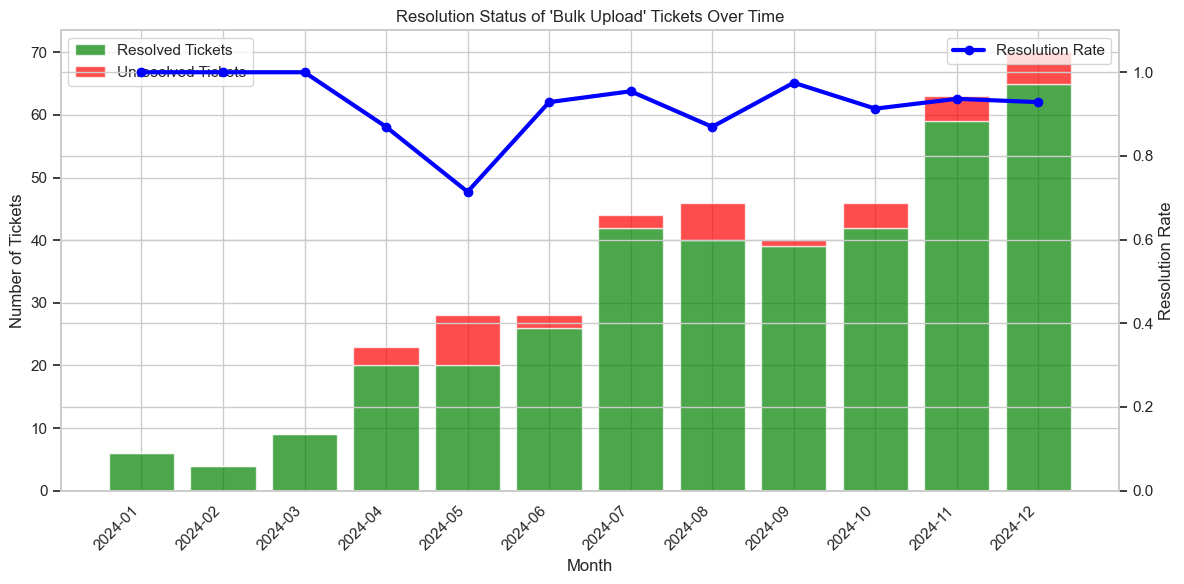

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('combined_customer_tickets_dataset.csv')
df['created_at'] = pd.to_datetime(df['created_at'])

# Drop rows with missing creation dates
df = df.dropna(subset=['created_at'])

# Filter for tickets containing "bulk upload" (case insensitive)
bulk_tickets = df[df['ticket_text'].astype(str).str.contains('bulk upload', case=False, na=False)].copy()

# Group by Month and Resolution Status
bulk_tickets['month_year'] = bulk_tickets['created_at'].dt.to_period('M')

# Calculate counts of resolved vs unresolved per month
monthly_resolution = bulk_tickets.groupby(['month_year', 'resolved']).size().unstack(fill_value=0)

# Ensure both columns exist (0 and 1)
if 0 not in monthly_resolution.columns:
    monthly_resolution[0] = 0
if 1 not in monthly_resolution.columns:
    monthly_resolution[1] = 0

# Rename for clarity
monthly_resolution.columns = ['Unresolved', 'Resolved']

# Sort index
monthly_resolution = monthly_resolution.sort_index()

# Calculate Resolution Rate
monthly_resolution['Total'] = monthly_resolution['Resolved'] + monthly_resolution['Unresolved']
monthly_resolution['Resolution Rate'] = monthly_resolution['Resolved'] / monthly_resolution['Total']

# Convert index to string for plotting
monthly_resolution.index = monthly_resolution.index.astype(str)

print("Monthly Resolution Stats for 'Bulk Upload' Tickets:")
print(monthly_resolution)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Stacked Bar Chart for Volume
ax1.bar(monthly_resolution.index, monthly_resolution['Resolved'], label='Resolved Tickets', color='green', alpha=0.7)
ax1.bar(monthly_resolution.index, monthly_resolution['Unresolved'], bottom=monthly_resolution['Resolved'], label='Unresolved Tickets', color='red', alpha=0.7)

ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Tickets')
ax1.legend(loc='upper left')
ax1.set_xticklabels(monthly_resolution.index, rotation=45, ha='right')

# Line Chart for Resolution Rate on Secondary Axis
ax2 = ax1.twinx()
ax2.plot(monthly_resolution.index, monthly_resolution['Resolution Rate'], color='blue', marker='o', linewidth=3, label='Resolution Rate')
ax2.set_ylabel('Resolution Rate')
ax2.set_ylim(0, 1.1)
ax2.legend(loc='upper right')

plt.title("Resolution Status of 'Bulk Upload' Tickets Over Time")
plt.tight_layout()
plt.savefig('bulk_upload_resolution.png')

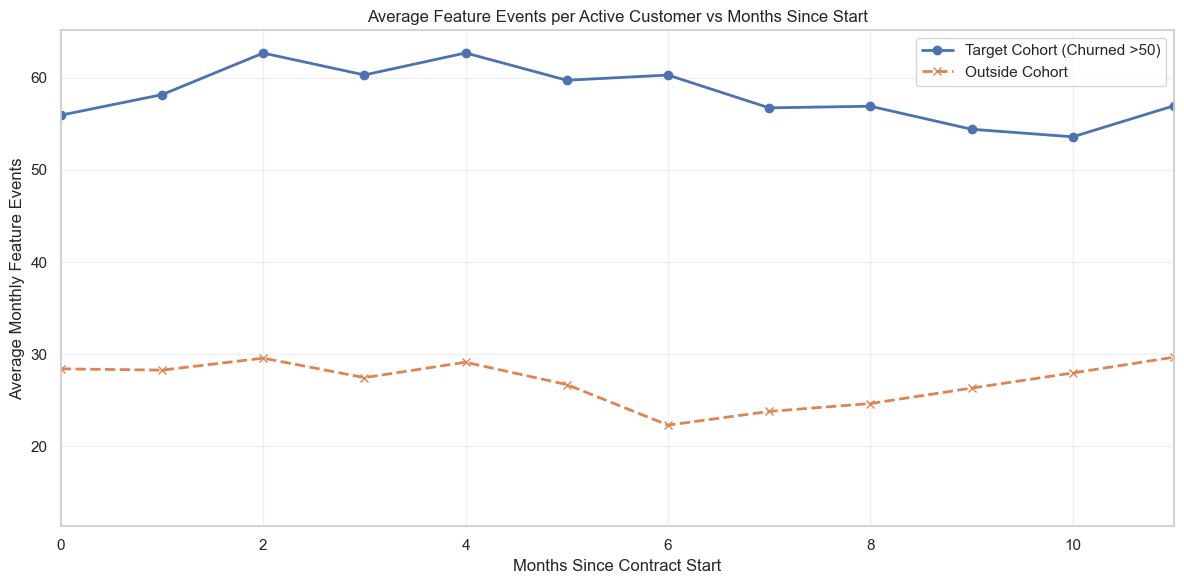

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Customer Metadata
df_customers = pd.read_csv('combined_customer_tickets_dataset.csv')
# Keep unique customers with necessary columns
customer_meta = df_customers.drop_duplicates(subset=['customer_id'])[['customer_id', 'contract_start_date', 'company_size_bucket', 'is_churned', 'is_eu']]
customer_meta['contract_start_date'] = pd.to_datetime(customer_meta['contract_start_date'])

# 2. Load Usage Data
df_usage_q1q2 = pd.read_csv('dataset2a for q1 q2.csv')
df_usage_q3q4 = pd.read_csv('dataset2b for q3 q4.csv')
df_usage = pd.concat([df_usage_q1q2, df_usage_q3q4], ignore_index=True)
df_usage['date'] = pd.to_datetime(df_usage['date'])

# 3. Merge Metadata into Usage
# We use inner join to keep only valid customers
df_merged = pd.merge(df_usage, customer_meta, on='customer_id', how='inner')

# 4. Apply "European server logs corrupted for September" fix
# Filter out: is_eu == 1 AND date in September
# Assuming the data is for 2024 based on file names "dataset2..." and snippets showing 2024.
# We'll filter any September just to be safe, or specifically Sept 2024.
mask_eu_sept = (df_merged['is_eu'] == 1) & (df_merged['date'].dt.month == 9)
# We exclude these rows
df_clean = df_merged[~mask_eu_sept].copy()

# 5. Calculate Relative Time (Months Since Start)
df_clean['days_since_start'] = (df_clean['date'] - df_clean['contract_start_date']).dt.days
df_clean['months_since_start'] = np.floor(df_clean['days_since_start'] / 30.44).astype(int)

# Filter for reasonable range (e.g., 0 to 12 months, matching previous graph)
df_clean = df_clean[(df_clean['months_since_start'] >= 0) & (df_clean['months_since_start'] <= 12)]

# 6. Define Cohorts
q3_start = pd.Timestamp('2023-07-01')
target_sizes = ['51-200', '201-1000', '1000+']

# Target Cohort IDs (Churned, Start >= Q3 2023, Size > 50)
target_mask =(customer_meta['contract_start_date'] >= q3_start) & \
              (customer_meta['company_size_bucket'].isin(target_sizes))
target_ids = customer_meta.loc[target_mask, 'customer_id'].unique()

# Outside Cohort IDs (Everyone else)
all_ids = customer_meta['customer_id'].unique()
outside_ids = np.setdiff1d(all_ids, target_ids)

# 7. Calculate Aggregates
# We want Average Usage per Customer per Month.
# We need the count of customers in the cohort *who could statistically have data*?
# Or just the average of the usage rows present?
# Usually, if a customer is active, they have rows. If they churned, they stop having rows (or have 0).
# The usage dataset seems to have daily rows.
# If a customer doesn't have a row for a day, is it 0 usage or missing?
# Assuming daily logs, we should aggregate to Monthly Sum per Customer, then Average across Customers.

# First, aggregate daily usage to monthly usage per customer
monthly_customer_usage = df_clean.groupby(['customer_id', 'months_since_start'])['feature_events'].sum().reset_index()

# Now split into cohorts
target_usage = monthly_customer_usage[monthly_customer_usage['customer_id'].isin(target_ids)]
outside_usage = monthly_customer_usage[monthly_customer_usage['customer_id'].isin(outside_ids)]

# Calculate Average per Month
# Note: This average is over customers *present* in that relative month.
# If a customer churns at month 6, they won't be in month 7 data.
# This is usually what we want for "Average Usage of Active Users" or we might want "Average Usage of Cohort" (treating churn as 0).
# Given the user compares "usage", usually "Average Usage of Survivors" or "Average Usage" is fine.
# Let's stick to simple average of the data points we have (Average usage of active customers).
# Be careful: If the target group churns, the 'survivors' might be high usage?
# Or if they churn because of the bug, their usage might drop before churn.
# Let's plot Average Feature Events per Active Customer.

avg_target = target_usage.groupby('months_since_start')['feature_events'].mean()
avg_outside = outside_usage.groupby('months_since_start')['feature_events'].mean()

# Align
all_months = sorted(list(set(avg_target.index) | set(avg_outside.index)))
avg_target = avg_target.reindex(all_months)
avg_outside = avg_outside.reindex(all_months)

# 8. Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_target.index, avg_target.values, marker='o', label='Target Cohort (Churned >50)', linewidth=2)
plt.plot(avg_outside.index, avg_outside.values, marker='x', label='Outside Cohort', linestyle='--', linewidth=2)

plt.title('Average Feature Events per Active Customer vs Months Since Start')
plt.xlabel('Months Since Contract Start')
plt.ylabel('Average Monthly Feature Events')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 11)
plt.tight_layout()
plt.savefig('usage_comparison.png')

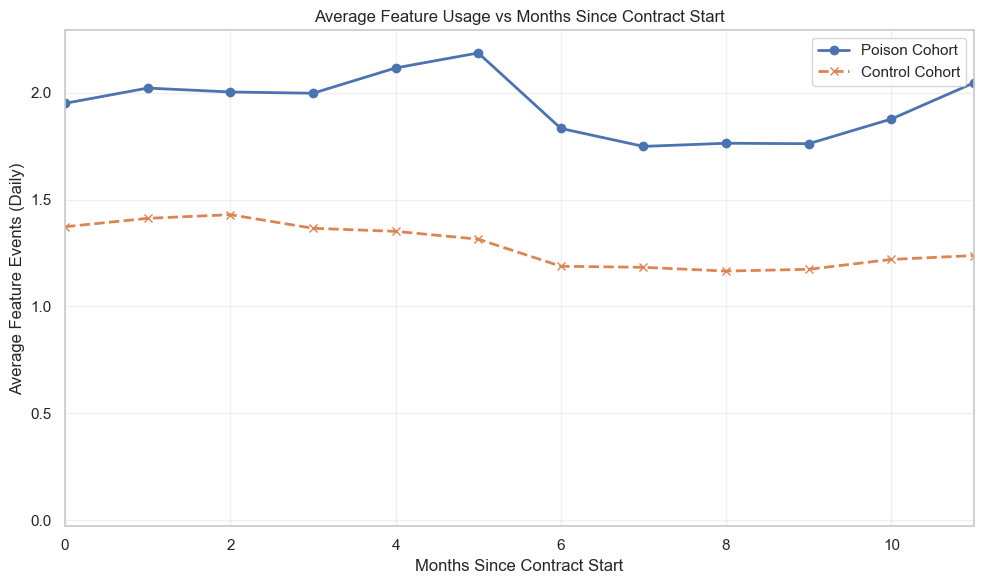

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Customer Metadata
df_cust = pd.read_csv('combined_customer_tickets_dataset.csv')
cust_meta = df_cust.drop_duplicates(subset=['customer_id'])[['customer_id', 'contract_start_date', 'company_size_bucket', 'is_churned', 'is_eu']]
cust_meta['contract_start_date'] = pd.to_datetime(cust_meta['contract_start_date'])

# 2. Define Cohorts
q3_start = pd.Timestamp('2023-07-01')
target_sizes = ['51-200', '201-1000', '1000+']

target_mask = (cust_meta['is_churned'] == 1) & \
              (cust_meta['contract_start_date'] >= q3_start) & \
              (cust_meta['company_size_bucket'].isin(target_sizes))

target_ids_set = set(cust_meta.loc[target_mask, 'customer_id'].unique())

def get_cohort(cid):
    if cid in target_ids_set:
        return 'Poison Cohort' # Renamed from 'Target Cohort'
    else:
        return 'Control Cohort' # Renamed from 'Outside Cohort'

cust_meta['cohort'] = cust_meta['customer_id'].apply(get_cohort)

# 3. Load Usage Data
df_usage_1 = pd.read_csv('dataset2a for q1 q2.csv')
df_usage_2 = pd.read_csv('dataset2b for q3 q4.csv')
df_usage = pd.concat([df_usage_1, df_usage_2], ignore_index=True)
df_usage['date'] = pd.to_datetime(df_usage['date'])

# 4. Merge
df_merged = df_usage.merge(cust_meta, on='customer_id', how='inner')

# 5. Filter Corrupted Data (EU & September)
mask_corrupt = (df_merged['is_eu'] == 1) & (df_merged['date'].dt.month == 9)
df_clean = df_merged[~mask_corrupt].copy()

# 6. Calculate Relative Time
df_clean['days_since_start'] = (df_clean['date'] - df_clean['contract_start_date']).dt.days
df_clean['months_since_start'] = np.floor(df_clean['days_since_start'] / 30.44).astype(int)

# Filter for 0 to 12 months
df_final = df_clean[(df_clean['months_since_start'] >= 0) & (df_clean['months_since_start'] <= 12)]

# 7. Aggregate Usage
grouped = df_final.groupby(['cohort', 'months_since_start'])['feature_events'].mean().reset_index()
pivot_data = grouped.pivot(index='months_since_start', columns='cohort', values='feature_events')

# 8. Plot
plt.figure(figsize=(10, 6))
# Ensure columns exist before plotting
if 'Poison Cohort' in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data['Poison Cohort'], marker='o', label='Poison Cohort', linewidth=2)
if 'Control Cohort' in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data['Control Cohort'], marker='x', label='Control Cohort', linestyle='--', linewidth=2)

plt.xlabel('Months Since Contract Start')
plt.ylabel('Average Feature Events (Daily)')
plt.title('Average Feature Usage vs Months Since Contract Start')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 11)
plt.tight_layout()
plt.savefig('usage_comparison_renamed.png')

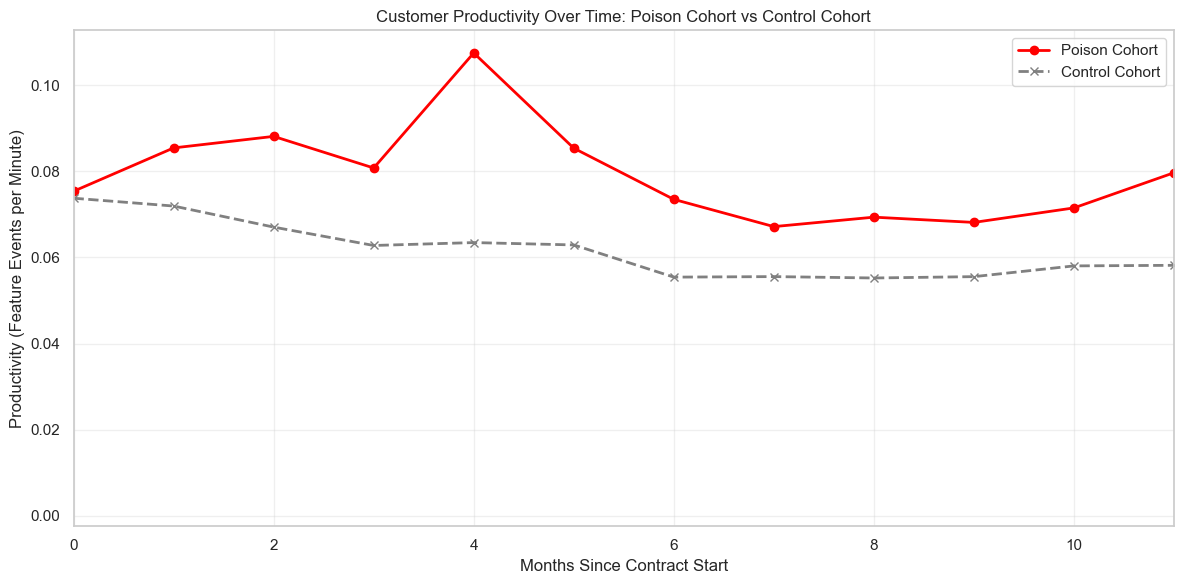

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Customer Metadata & Define Cohorts
df_cust = pd.read_csv('combined_customer_tickets_dataset.csv')
cust_meta = df_cust.drop_duplicates(subset=['customer_id'])[['customer_id', 'contract_start_date', 'company_size_bucket', 'is_churned', 'is_eu']]
cust_meta['contract_start_date'] = pd.to_datetime(cust_meta['contract_start_date'])

q3_start = pd.Timestamp('2023-07-01')
q3_end = pd.Timestamp('2023-09-30')
target_sizes = ['51-200', '201-1000', '1000+']

# Poison Cohort: Churned, Start in Q3 2023, Size > 50
poison_mask = (cust_meta['is_churned'] == 1) & \
              (cust_meta['contract_start_date'] >= q3_start) & \
              (cust_meta['company_size_bucket'].isin(target_sizes))

poison_ids_set = set(cust_meta.loc[poison_mask, 'customer_id'].unique())

def get_cohort(cid):
    if cid in poison_ids_set:
        return 'Poison Cohort'
    else:
        return 'Control Cohort'

cust_meta['cohort'] = cust_meta['customer_id'].apply(get_cohort)

# 2. Load Usage Data
df_usage_1 = pd.read_csv('dataset2a for q1 q2.csv')
df_usage_2 = pd.read_csv('dataset2b for q3 q4.csv')
df_usage = pd.concat([df_usage_1, df_usage_2], ignore_index=True)
df_usage['date'] = pd.to_datetime(df_usage['date'])

# 3. Merge Usage with Metadata
df_merged = df_usage.merge(cust_meta, on='customer_id', how='inner')

# 4. Filter Corrupted Data (EU & September)
mask_corrupt = (df_merged['is_eu'] == 1) & (df_merged['date'].dt.month == 9)
df_clean = df_merged[~mask_corrupt].copy()

# 5. Calculate Metrics
# Productivity = feature_events / session_minutes
df_clean['productivity'] = df_clean['feature_events'] / df_clean['session_minutes']
df_clean.loc[df_clean['session_minutes'] == 0, 'productivity'] = 0 
df_clean['productivity'] = df_clean['productivity'].fillna(0)

# Relative Time
df_clean['days_since_start'] = (df_clean['date'] - df_clean['contract_start_date']).dt.days
df_clean['months_since_start'] = np.floor(df_clean['days_since_start'] / 30.44).astype(int)

# Filter for 0 to 12 months
df_final = df_clean[(df_clean['months_since_start'] >= 0) & (df_clean['months_since_start'] <= 12)]

# 6. Aggregate
grouped = df_final.groupby(['cohort', 'months_since_start'])['productivity'].mean().reset_index()
pivot_data = grouped.pivot(index='months_since_start', columns='cohort', values='productivity')

# 7. Plot
plt.figure(figsize=(12, 6))

if 'Poison Cohort' in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data['Poison Cohort'], marker='o', label='Poison Cohort', linewidth=2, color='red')
if 'Control Cohort' in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data['Control Cohort'], marker='x', label='Control Cohort', linestyle='--', linewidth=2, color='gray')

plt.xlabel('Months Since Contract Start')
plt.ylabel('Productivity (Feature Events per Minute)')
plt.title('Customer Productivity Over Time: Poison Cohort vs Control Cohort')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 11)
plt.tight_layout()
plt.savefig('productivity_comparison.png')